In [2]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering, HDBSCAN
from sklearn.metrics import adjusted_rand_score, confusion_matrix, f1_score, precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from tqdm import tqdm
from gorillatracker.classification.metrics import analyse_embedding_space, formatted_names
from scipy.optimize import linear_sum_assignment
from scipy.interpolate import UnivariateSpline
from tempfile import mkdtemp


def calculate_metrics(embeddings: np.ndarray, labels: np.ndarray, true_labels: np.ndarray) -> dict:
    """wraps analyse_embedding_space and adds class-weighted F1 score and precision"""
    assert len(labels) == len(true_labels) == len(embeddings)
    df = pd.DataFrame({"embedding": embeddings.tolist(), "label": labels.tolist()})
    metrics = analyse_embedding_space(df)

    # "label matching problem" in clustering evaluation
    matched_labels = match_labels(true_labels, labels)

    # Compute class-weighted F1 score
    f1 = f1_score(true_labels, matched_labels, average="weighted")

    # Compute class-weighted precision
    precision = precision_score(true_labels, matched_labels, average="weighted")

    # NOTE(liamvdv): not over matched labels, can handle arbitrary cluster labels
    # https://en.wikipedia.org/wiki/Rand_index#/media/File:Example_for_Adjusted_Rand_index.svg
    # https://scikit-learn.org/stable/modules/generated/sklearn.metrics.adjusted_rand_score.html
    # The adjusted Rand index is thus ensured to have a value close to 0.0 for random labeling independently of the number of clusters and samples and exactly 1.0 when the clusterings are identical (up to a permutation). The adjusted Rand index is bounded below by -0.5 for especially discordant clusterings.
    ars = adjusted_rand_score(true_labels, labels)

    metrics.update({"weighted_f1_score": f1, "weighted_precision": precision, "adjusted_rand_score": ars})
    return metrics


def match_labels(true_labels, predicted_labels):
    """
    Match predicted cluster labels to true labels using the Hungarian algorithm.

    NOTE(liamvdv): Necessary because cluster labels are arbitrary and may not match the true labels but represent the same clusters.
    """
    assert len(true_labels) == len(predicted_labels)

    # Create confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Use the Hungarian algorithm to find the best matching
    row_ind, col_ind = linear_sum_assignment(-cm)

    label_mapping = {pred: true for pred, true in zip(col_ind, row_ind)}

    matched_labels = np.array([label_mapping.get(label, label) for label in predicted_labels])

    return matched_labels


def find_elbow(inertias: list[float]) -> int:
    """Find the elbow point in a list of inertia (wcss) values."""
    # Create x-axis values (number of clusters)
    x: np.ndarray = np.arange(1, len(inertias) + 1)

    # Fit a smooth curve to the inertia data
    spline: UnivariateSpline = UnivariateSpline(x, inertias, s=0)

    # Calculate the second derivative
    second_derivative: np.ndarray = spline.derivative(n=2)(x)

    # Find the point of maximum curvature (elbow)
    elbow: int = np.argmax(np.abs(second_derivative)) + 1

    return elbow


def _run_kmeans(args):
    scaled_embeddings, k, true_labels = args
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(scaled_embeddings)
    metric = calculate_metrics(scaled_embeddings, labels, true_labels)
    metric["algorithm"] = "K-means"
    metric["algorithm_arg"] = k
    return metric


def find_optimal_kmeans_parallel(embeddings, true_labels, max_clusters=30):
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)

    # Prepare arguments for parallel processing
    args_list = [(scaled_embeddings, k, true_labels) for k in range(2, max_clusters + 1)]

    metrics = []

    with ProcessPoolExecutor(max_workers=10) as executor:
        # Submit all jobs
        future_to_k = {executor.submit(_run_kmeans, args): args[1] for args in args_list}

        # Collect results as they complete
        for future in tqdm(as_completed(future_to_k), total=len(future_to_k), desc="Running K-means"):
            k = future_to_k[future]
            try:
                metric = future.result()
                metrics.append(metric)
            except Exception as exc:
                print(f"K-means for k={k} generated an exception: {exc}")

    # Sort metrics by number of clusters
    metrics.sort(key=lambda x: x["algorithm_arg"])

    return metrics


def find_optimal_kmeans(embeddings, true_labels, max_clusters=30, step=1):
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)

    metrics = []

    for k in tqdm(range(2, max_clusters + 1, step), desc="Running K-means", total=max_clusters // step):
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(scaled_embeddings)
        metric = calculate_metrics(scaled_embeddings, labels, true_labels)
        metric["algorithm"] = "K-means"
        metric["algorithm_arg"] = k
        metrics.append(metric)

    return metrics


def find_optimal_eps_for_dbscan(embeddings):
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)

    # Find optimal eps
    """
    The purpose of this code is to create what's called a "k-distance graph". This graph, when plotted, shows the distance to the nearest neighbor for each point, sorted in ascending order. It's used to help determine a good value for the 'eps' parameter in DBSCAN.
    
    In a k-distance graph, you typically look for an "elbow" - a point where the distance starts increasing more rapidly. This elbow often indicates a good value for 'eps'. Points before the elbow are considered "close" to their neighbors and might form clusters, while points after the elbow are farther from their neighbors and might be considered noise or outliers.
    """
    neighbors = NearestNeighbors(n_neighbors=2)
    neighbors_fit = neighbors.fit(scaled_embeddings)
    distances, indices = neighbors_fit.kneighbors(scaled_embeddings)
    distances = np.sort(distances, axis=0)
    distances = distances[:, 1]

    plt.figure(figsize=(10, 5))
    plt.plot(distances)
    plt.xlabel("Points")
    plt.ylabel("Distance")
    plt.title("K-distance Graph")
    plt.show()

    print("Please examine the K-distance graph and input the 'elbow' point for eps:")
    eps = float(input("Enter the eps value: "))

    return eps


def find_optimal_dbscan(embeddings, true_labels, eps: float):
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)

    # Find optimal min_samples
    metrics = []
    min_samples_range = range(2, 11)

    for min_samples in min_samples_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(scaled_embeddings)
        metric = calculate_metrics(scaled_embeddings, labels, true_labels)
        metric["algorithm"] = "DBSCAN"
        metric["algorithm_arg"] = min_samples
        metrics.append(metric)

    return metrics


def find_optimal_hdbscan(
    embeddings: np.ndarray, true_labels, min_cluster_size_range: range = range(2, 10), min_samples: int = None
):
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)

    metrics = []

    for min_cluster_size in tqdm(min_cluster_size_range, desc="Running HDBSCAN"):
        hdbscan = HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples)
        labels = hdbscan.fit_predict(scaled_embeddings)

        metric = calculate_metrics(scaled_embeddings, labels, true_labels)
        metric["algorithm"] = "HDBSCAN"
        metric["algorithm_arg"] = min_cluster_size
        metrics.append(metric)

    return metrics


def find_optimal_agglomerative(embeddings: np.ndarray, true_labels, max_clusters: int = 30, step: int = 1):
    scaler = StandardScaler()
    scaled_embeddings = scaler.fit_transform(embeddings)

    # Create a temporary directory for caching
    cachedir = mkdtemp()
    metrics = []

    # Iterate from 2 to max_clusters
    for k in tqdm(range(2, max_clusters + 1, step), desc="Running Agglomerative", total=max_clusters // step):
        # Perform Agglomerative Clustering with k clusters
        # TODO(liamvdv): use cahcing: cachedir = mkdtemp(); memory = Memory(cachedir=cachedir, verbose=0)
        agg_clustering = AgglomerativeClustering(n_clusters=k, linkage="ward", memory=cachedir)
        labels = agg_clustering.fit_predict(scaled_embeddings)

        metric = calculate_metrics(scaled_embeddings, labels, true_labels)
        metric["algorithm"] = "Agglomerative Clustering"
        metric["algorithm_arg"] = k
        metrics.append(metric)

    return metrics


# agg_metrics = find_optimal_agglomerative(embeddings, true_labels, max_clusters=30)
# eps = find_optimal_eps_for_dbscan(embeddings)
# dbscan_metrics = find_optimal_dbscan(embeddings, true_labels, eps)

In [3]:
import matplotlib.pyplot as plt
import math


def visualize_alg_metrics(in_metrics, formatted_names):
    """
    Create a grid of charts where every metric is shown for in_metrics.

    Parameters:
    in_metrics (list): List of dictionaries containing metrics for each run
    formatted_names (dict): Dictionary mapping metric names to formatted display names

    Returns:
    None (displays the plot)
    """
    alg = in_metrics[0]["algorithm"]
    # Get the list of metrics (excluding 'algorithm' and 'algorithm_arg')
    metrics = [
        key
        for key in in_metrics[0].keys()
        if key not in ["algorithm", "algorithm_arg"] and not key.startswith("global_")
    ]

    # Calculate the grid dimensions
    n_metrics = len(metrics)
    n_cols = 5  # You can adjust this for a different layout
    n_rows = math.ceil(n_metrics / n_cols)

    # Create the plot
    fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 5 * n_rows))

    # Flatten the axs array for easier indexing
    axs = axs.flatten()

    # Plot each metric
    for i, metric in enumerate(metrics):
        x = [m["algorithm_arg"] for m in in_metrics]
        y = [m[metric] for m in in_metrics]

        axs[i].plot(x, y, marker="o")
        axs[i].set_title(formatted_names.get(metric, metric))
        axs[i].set_xlabel("Number of Clusters")
        axs[i].set_ylabel("Value")
        axs[i].grid(True)

    # Remove any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.tight_layout()
    plt.show()


def with_min_label_count(df: pd.DataFrame, min: int) -> pd.DataFrame:
    """
    Create a copy of the DataFrame, keeping only rows where the label appears
    at least 'min' times in the original DataFrame.

    Parameters:
    df (pd.DataFrame): Input DataFrame. Must have a 'label' column.
    min (int): Minimum number of occurrences for a label to be included.

    Returns:
    pd.DataFrame: A new DataFrame with filtered rows.

    Raises:
    ValueError: If 'label' column is not present in the DataFrame.
    """
    if "label" not in df.columns:
        raise ValueError("DataFrame must have a 'label' column")

    # Count label occurrences
    label_counts = df["label"].value_counts()

    # Get labels that appear at least 'min' times
    valid_labels = label_counts[label_counts >= min].index

    # Create a new DataFrame with only the valid labels
    filtered_df = df[df["label"].isin(valid_labels)].copy()

    return filtered_df


def upto_max_label_count(df: pd.DataFrame, max: int, seed: int = 42) -> pd.DataFrame:
    """
    Create a copy of the DataFrame, randomly sampling rows for labels that exceed
    the specified maximum count, while keeping all rows for labels that don't exceed the maximum.

    Parameters:
    df (pd.DataFrame): Input DataFrame. Must have a 'label' column.
    max (int): Maximum number of occurrences for each label.
    seed (int): Random seed for reproducibility.

    Returns:
    pd.DataFrame: A new DataFrame with sampled rows.

    Raises:
    ValueError: If 'label' column is not present in the DataFrame.
    """
    if "label" not in df.columns:
        raise ValueError("DataFrame must have a 'label' column")

    # Create a local random number generator
    rng = np.random.default_rng(seed)

    # Group the DataFrame by label
    grouped = df.groupby("label")

    sampled_dfs = []

    for label, group in grouped:
        if len(group) > max:
            # Randomly sample 'max' rows from the group
            sampled_group = group.sample(n=max, random_state=rng)
        else:
            # Keep all rows if the count doesn't exceed max
            sampled_group = group

        sampled_dfs.append(sampled_group)

    # Concatenate all sampled groups
    if len(sampled_dfs) == 0:
        return pd.DataFrame(columns=df.columns)
    else:
        return pd.concat(sampled_dfs).reset_index(drop=True)

In [5]:
MERGED_DF = pd.read_pickle("merged.pkl")

# K-Means

### SPAC  - ViT-Finetuned

Actual Number of Individuals 129


Running K-means:   0%|          | 0/36 [00:00<?, ?it/s]

/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running K-means:   3%|▎         | 1/36 [00:02<01:13,  2.10s/it]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running K-means:   6%|▌         | 2/36 [00:03<00:50,  1.48s/it]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

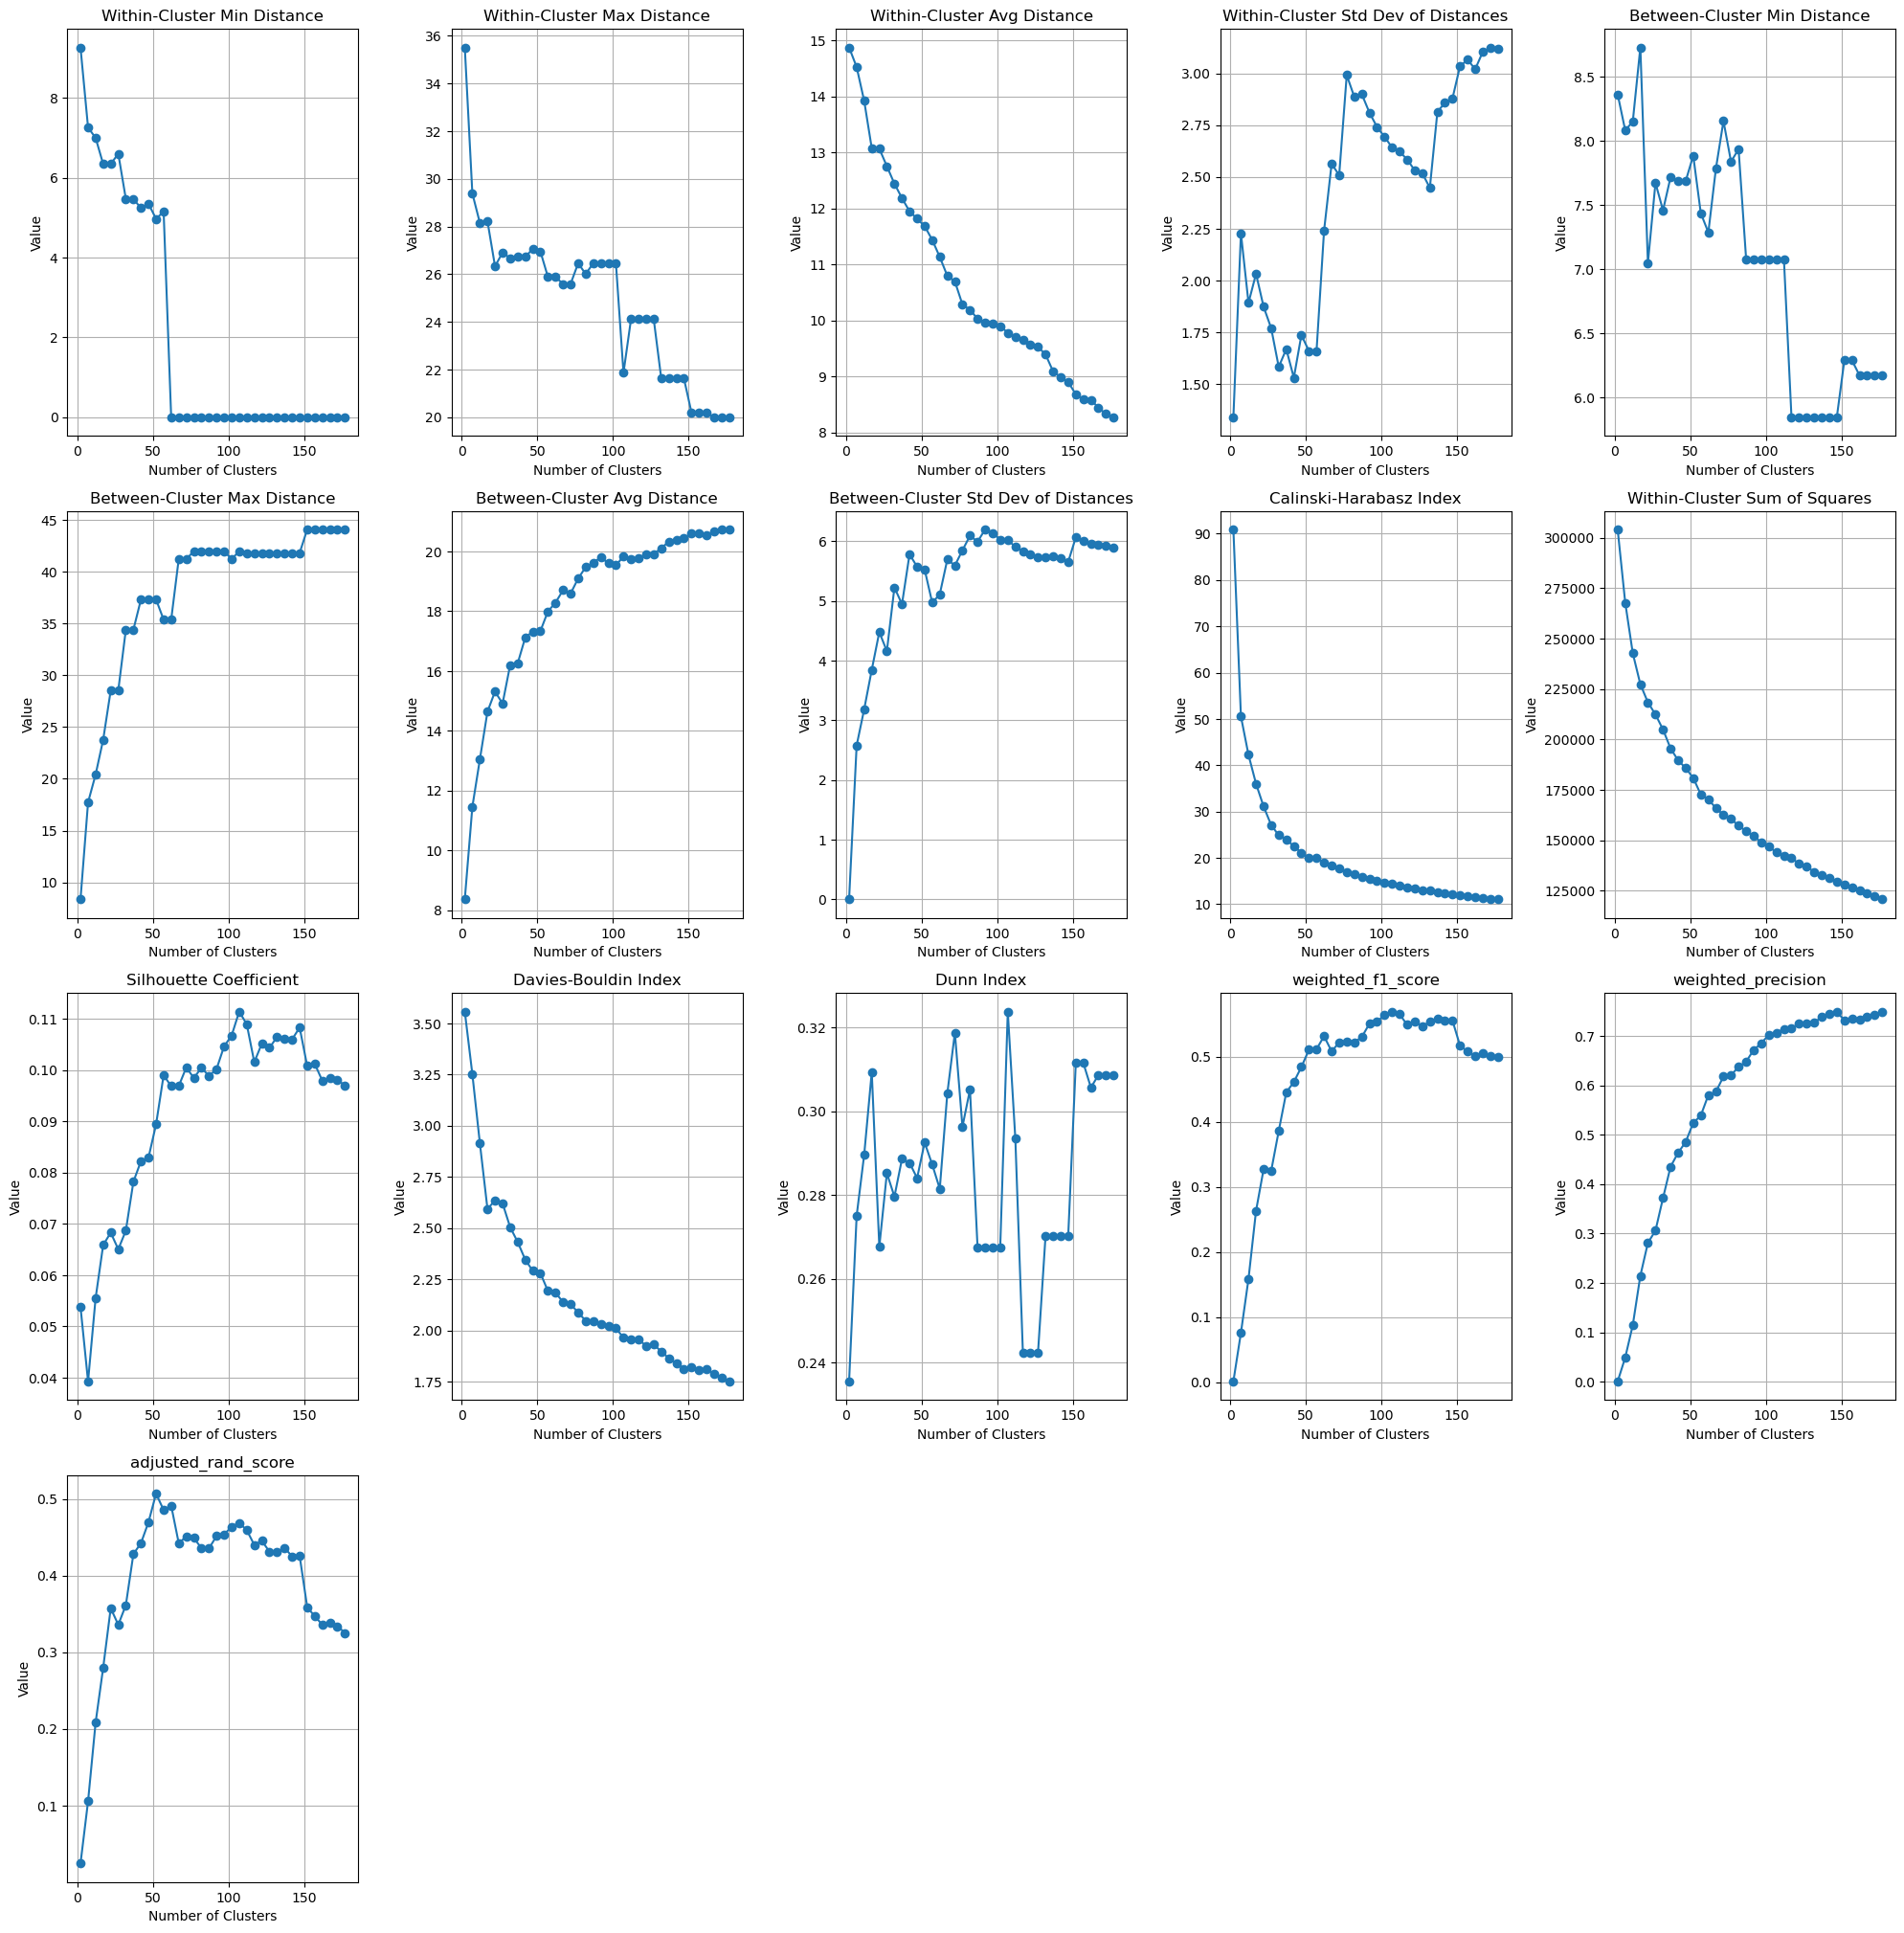

In [57]:
df = MERGED_DF
df = df[(df["model"] == "ViT-Finetuned") & (df["dataset"] == "SPAC")]
df = df.reset_index(drop=True)

embeddings = np.stack(df["embedding"].to_numpy())
true_labels = df["label"].to_numpy()

print("Actual Number of Individuals", len(np.unique(true_labels)))
kmeans_metrics = find_optimal_kmeans(embeddings, true_labels, max_clusters=180, step=5)
visualize_alg_metrics(kmeans_metrics, formatted_names)

Actual Number of Individuals 110


Running K-means:   0%|          | 0/32 [00:00<?, ?it/s]

/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running K-means:   3%|▎         | 1/32 [00:01<00:50,  1.62s/it]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running K-means:   6%|▋         | 2/32 [00:02<00:43,  1.45s/it]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

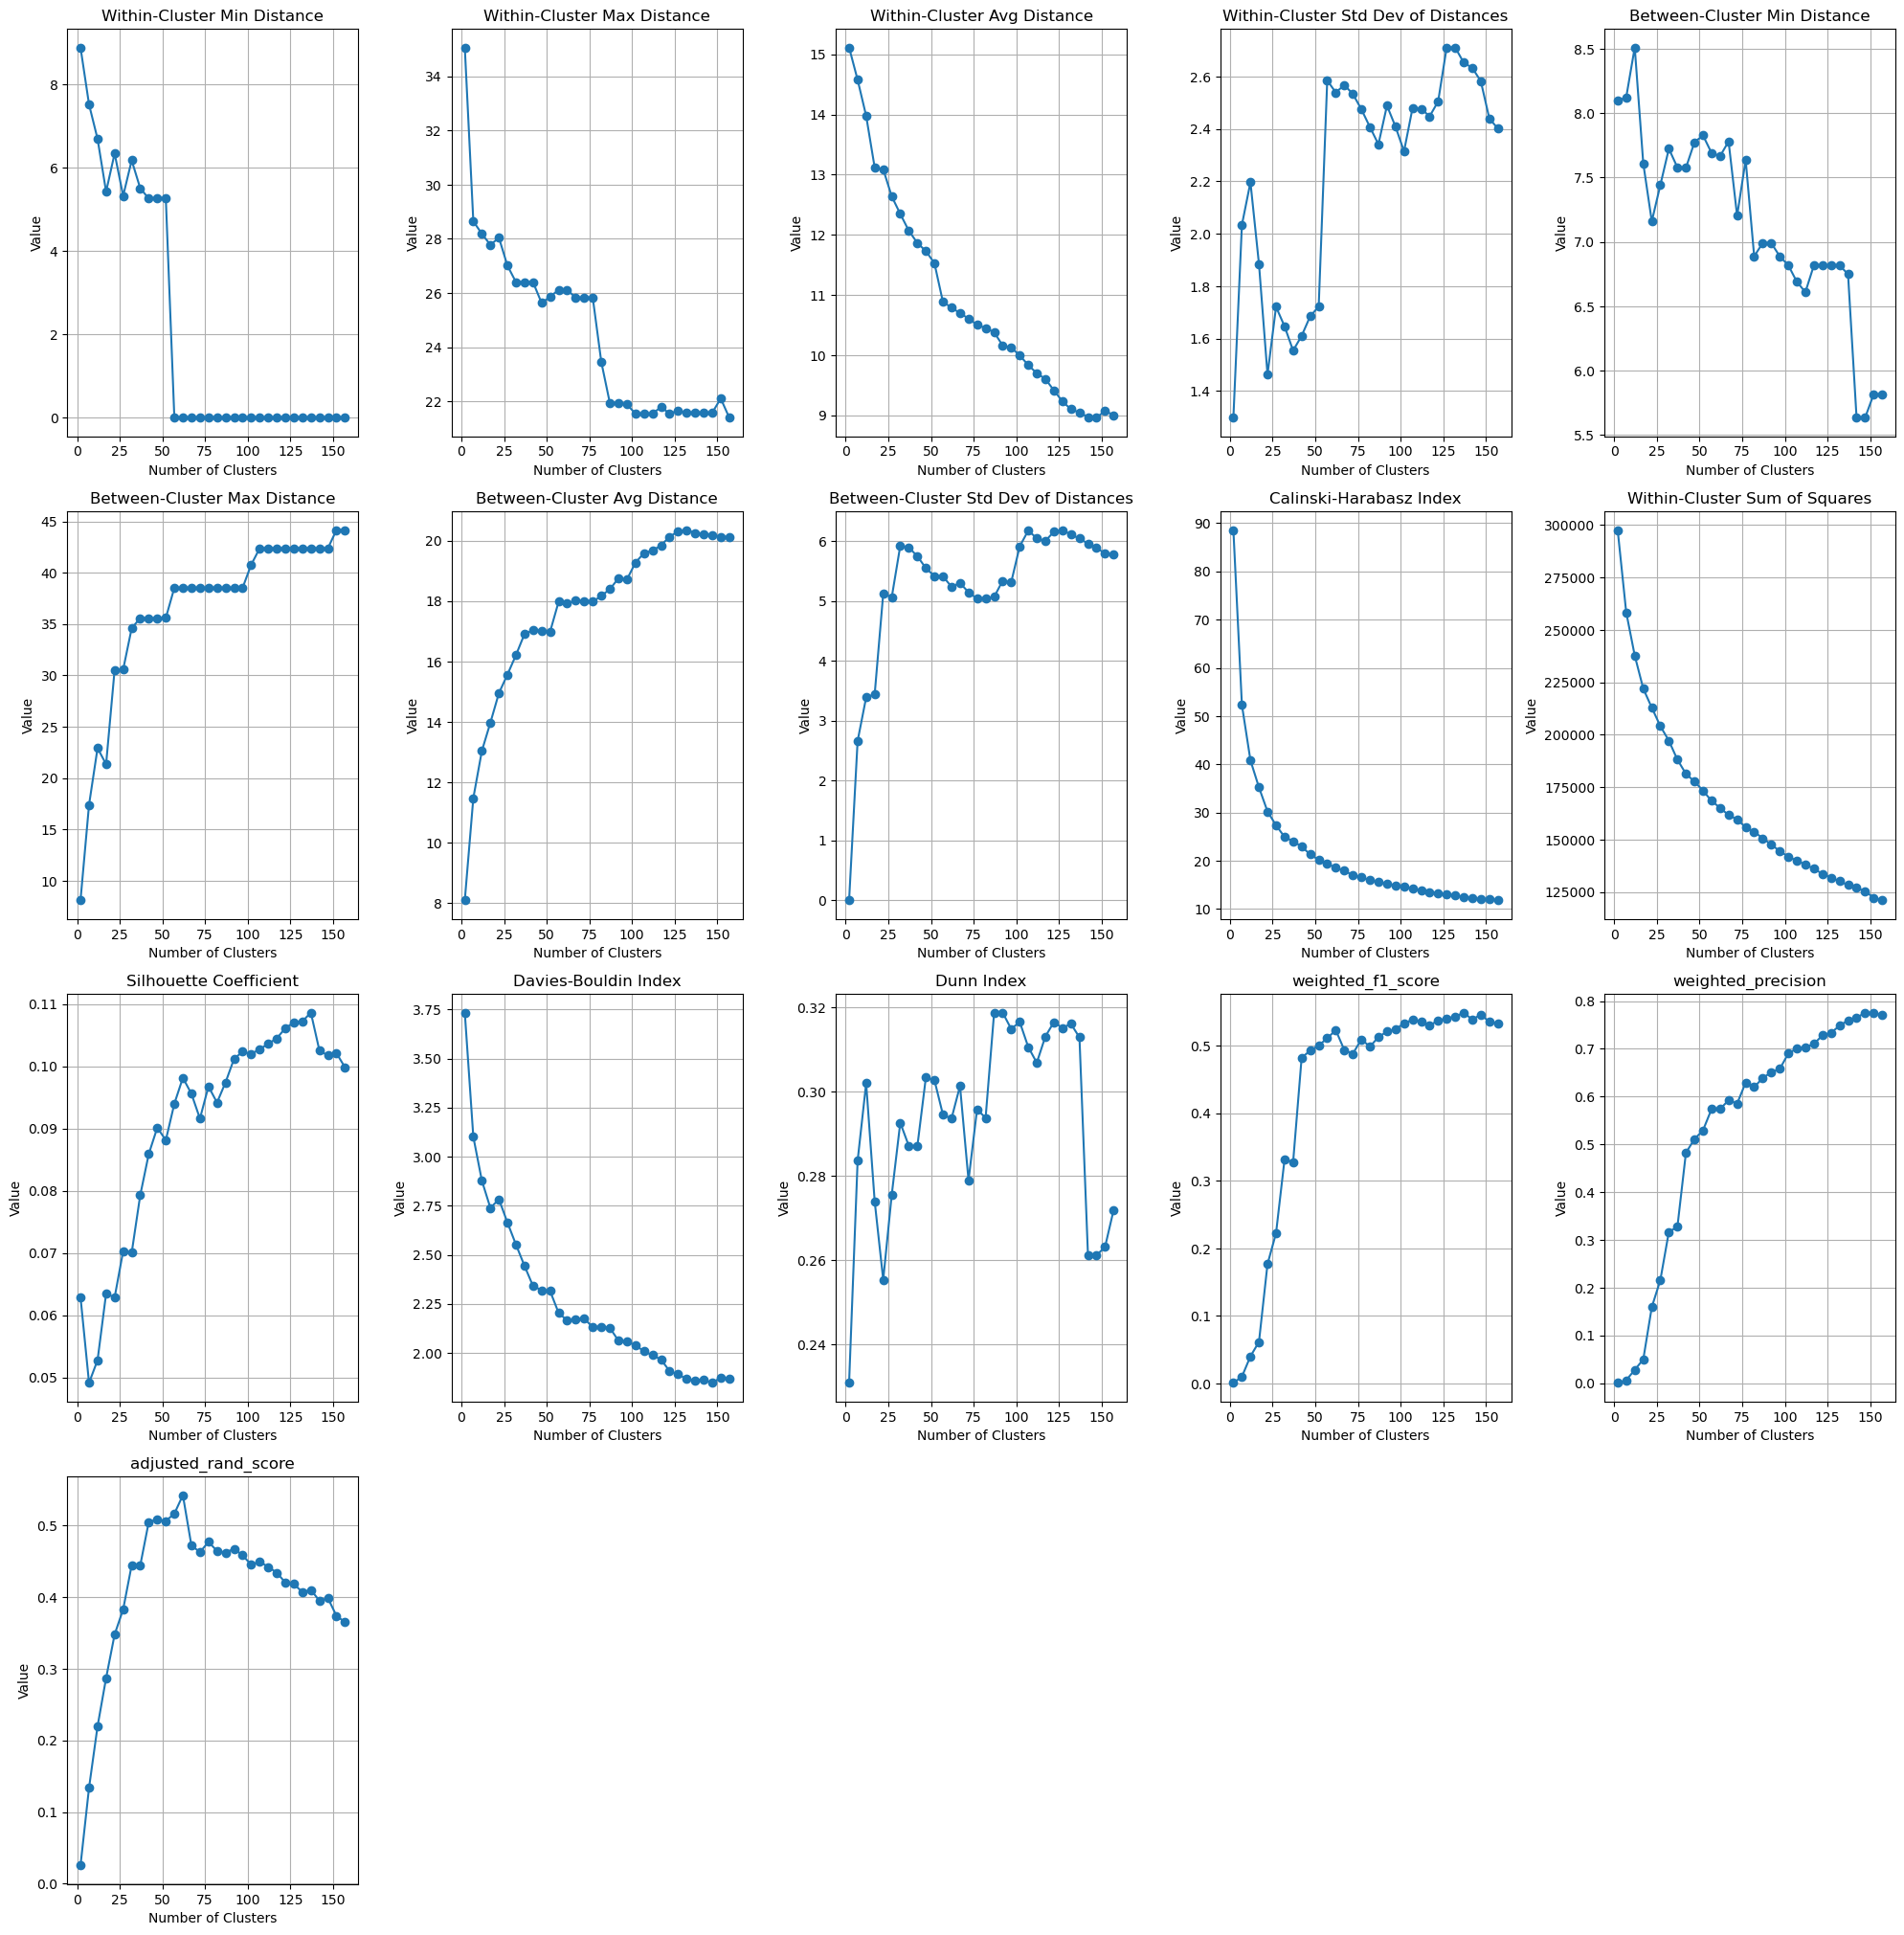

In [60]:
m3df = with_min_label_count(df, 3)
m3embeddings = np.stack(m3df["embedding"].to_numpy())
m3true_labels = m3df["label"].to_numpy()

print("Actual Number of Individuals", len(np.unique(m3true_labels)))
m3kmeans_metrics = find_optimal_kmeans(m3embeddings, m3true_labels, max_clusters=160, step=5)
visualize_alg_metrics(m3kmeans_metrics, formatted_names)

Actual Number of Individuals 110


Running K-means:   0%|          | 0/20 [00:00<?, ?it/s]

/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running K-means:   5%|▌         | 1/20 [00:00<00:16,  1.17it/s]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running K-means:  10%|█         | 2/20 [00:01<00:10,  1.72it/s]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

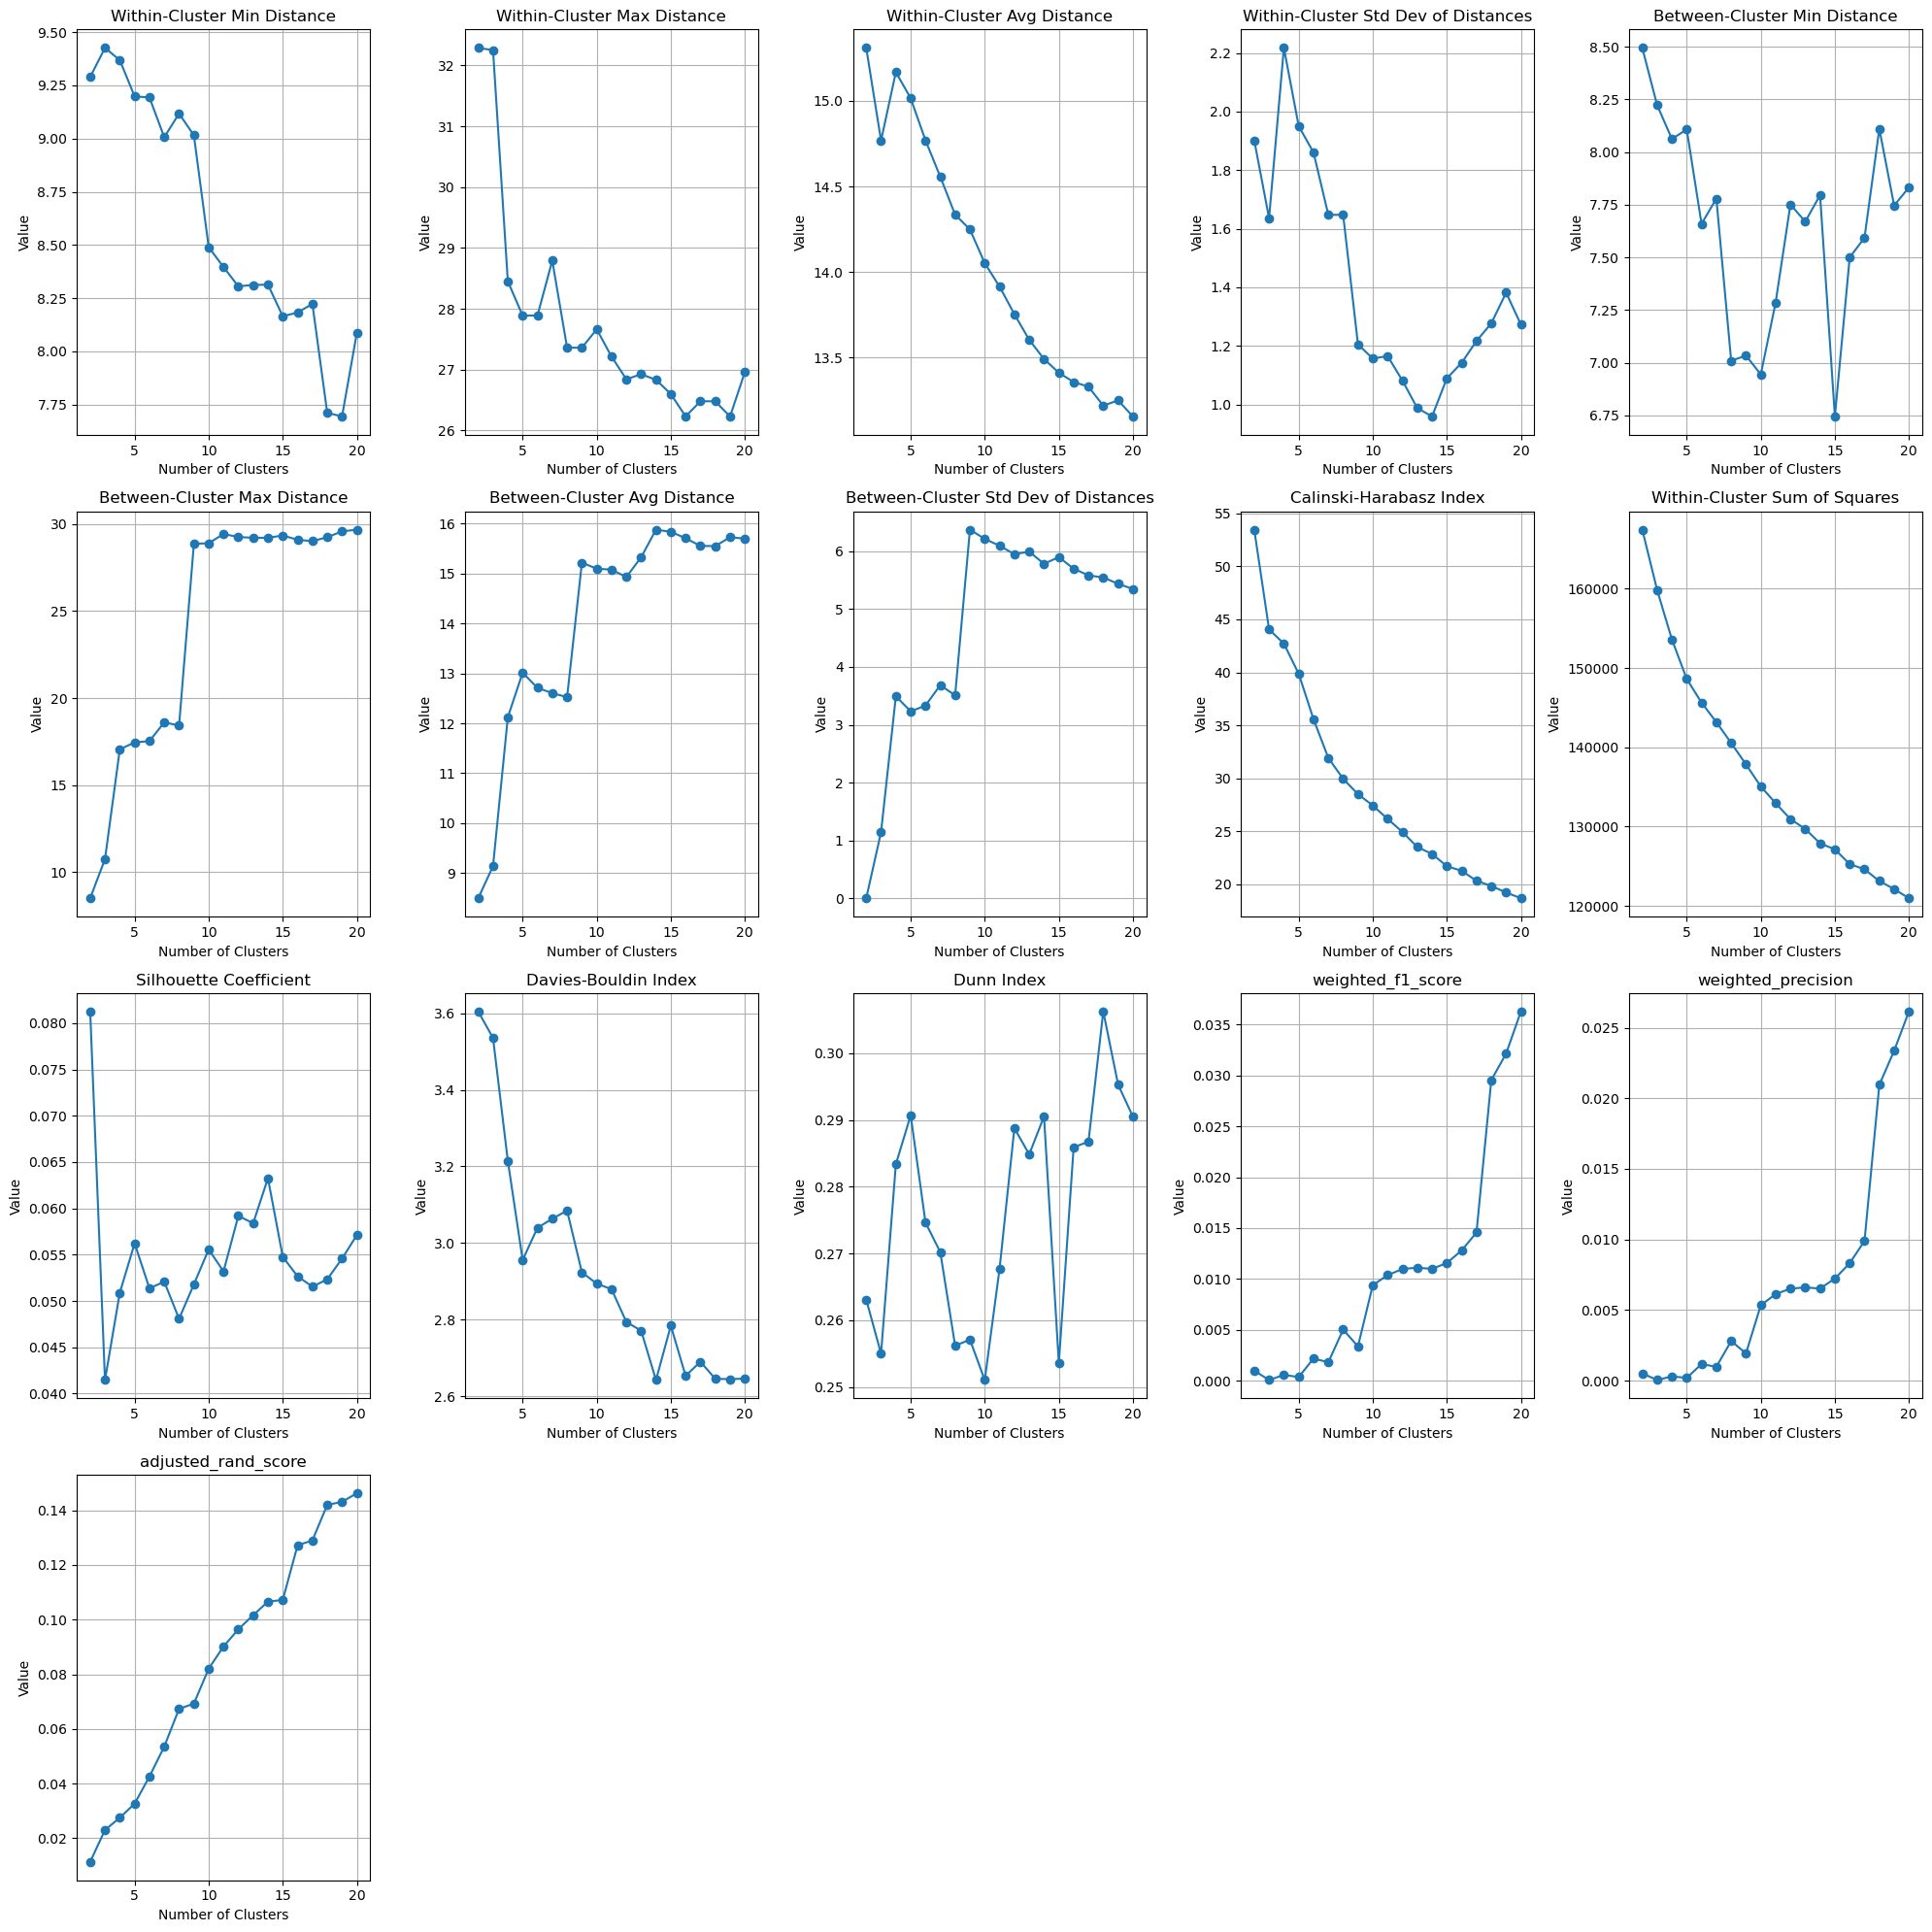

In [59]:
m3ma10df = upto_max_label_count(m3df, 10)
m3ma10embeddings = np.stack(m3ma10df["embedding"].to_numpy())
m3ma10true_labels = m3ma10df["label"].to_numpy()

print("Actual Number of Individuals", len(np.unique(m3ma10true_labels)))
m3ma10kmeans_metrics = find_optimal_kmeans(m3ma10embeddings, m3ma10true_labels, max_clusters=160, step=4)
visualize_alg_metrics(m3ma10kmeans_metrics, formatted_names)

### MNIST Test

Actual Number of Individuals 10


Running K-means:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running K-means:   5%|▌         | 1/20 [00:07<02:31,  7.98s/it]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running K-means:  10%|█         | 2/20 [00:12<01:48,  6.05s/it]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set

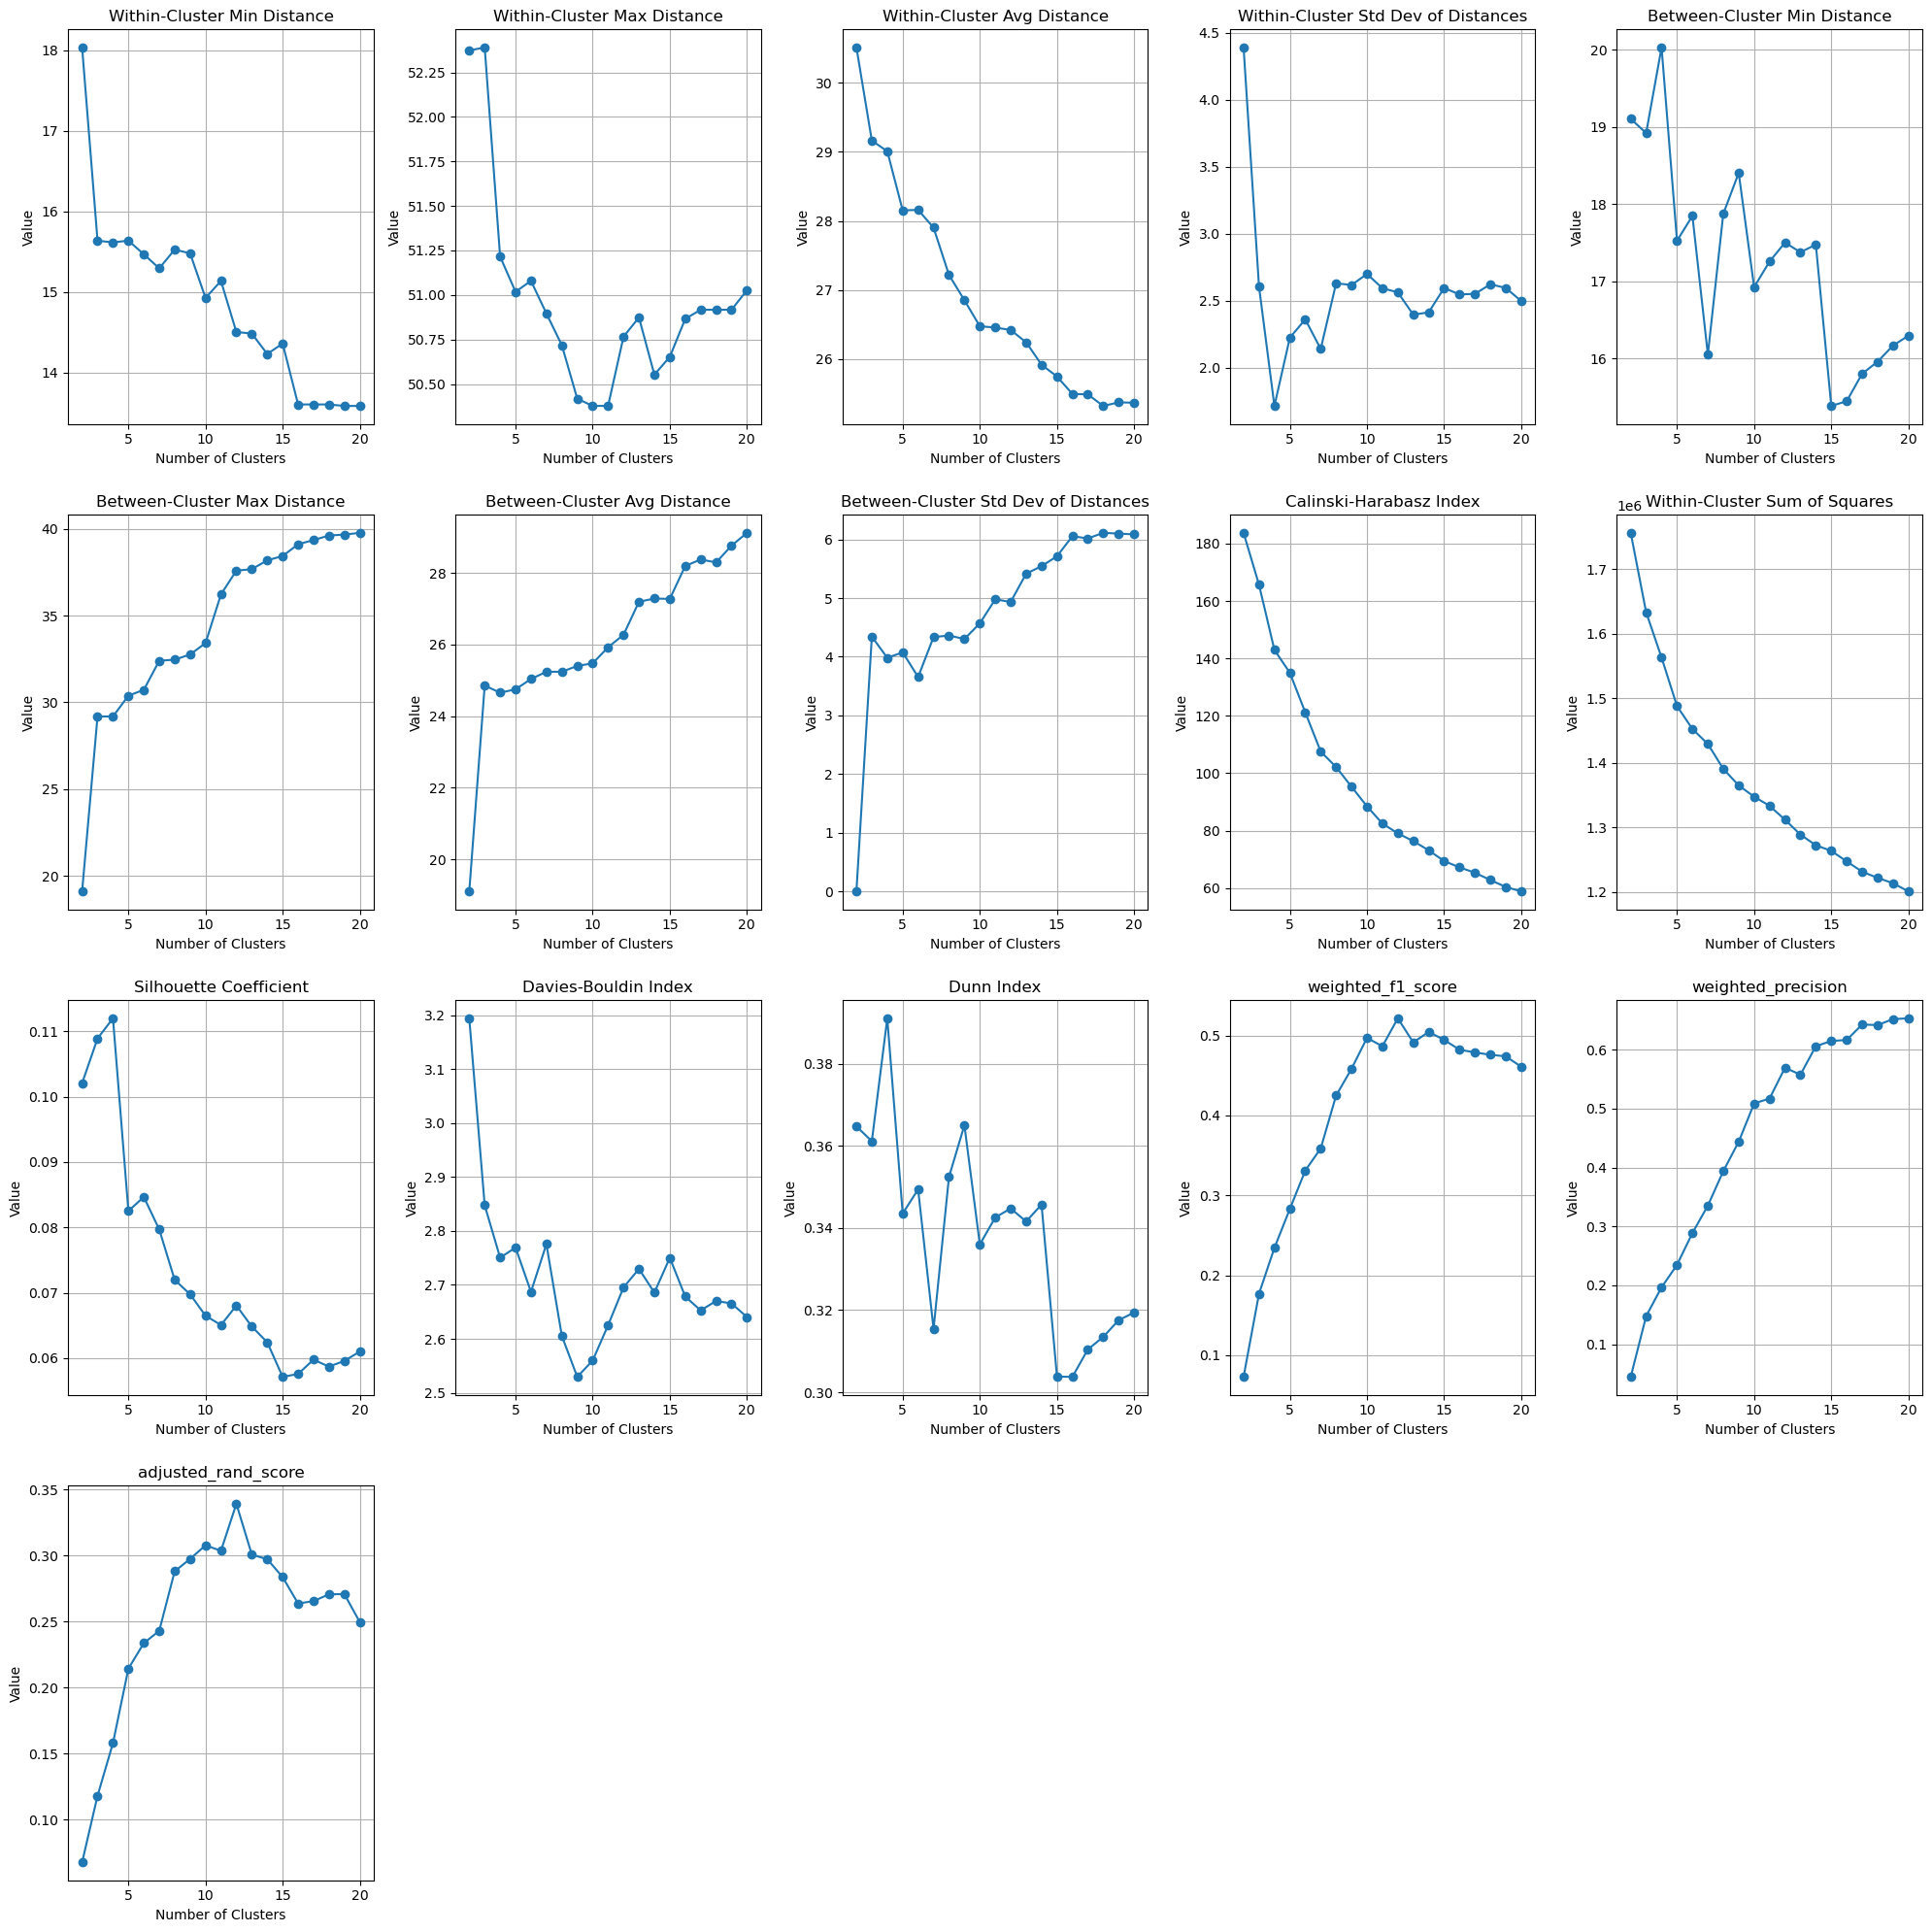

In [49]:
df = MERGED_DF
df = df[(df["model"] == "ViT-Pretrained") & (df["dataset"] == "MNIST")]
df = df.reset_index(drop=True)

embeddings = np.stack(df["embedding"].to_numpy())
true_labels = df["label"].to_numpy()

print("Actual Number of Individuals", len(np.unique(true_labels)))
kmeans_metrics = find_optimal_kmeans(embeddings, true_labels, max_clusters=20, step=1)
visualize_alg_metrics(kmeans_metrics, formatted_names)

### Synthetic Test Small (20 clusters; 20 images per cluster)

- Note that we might be off by 1-2 clusters if the starting K-Means initializiations points are in the same cluster. This is true if adjusted_rand_score cannot reach 1. (also reason for large dunn_index drop)

Actual Number of Individuals 20


Running K-means:   0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running K-means:   3%|▎         | 1/30 [00:00<00:21,  1.36it/s]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running K-means:   7%|▋         | 2/30 [00:01<00:16,  1.74it/s]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

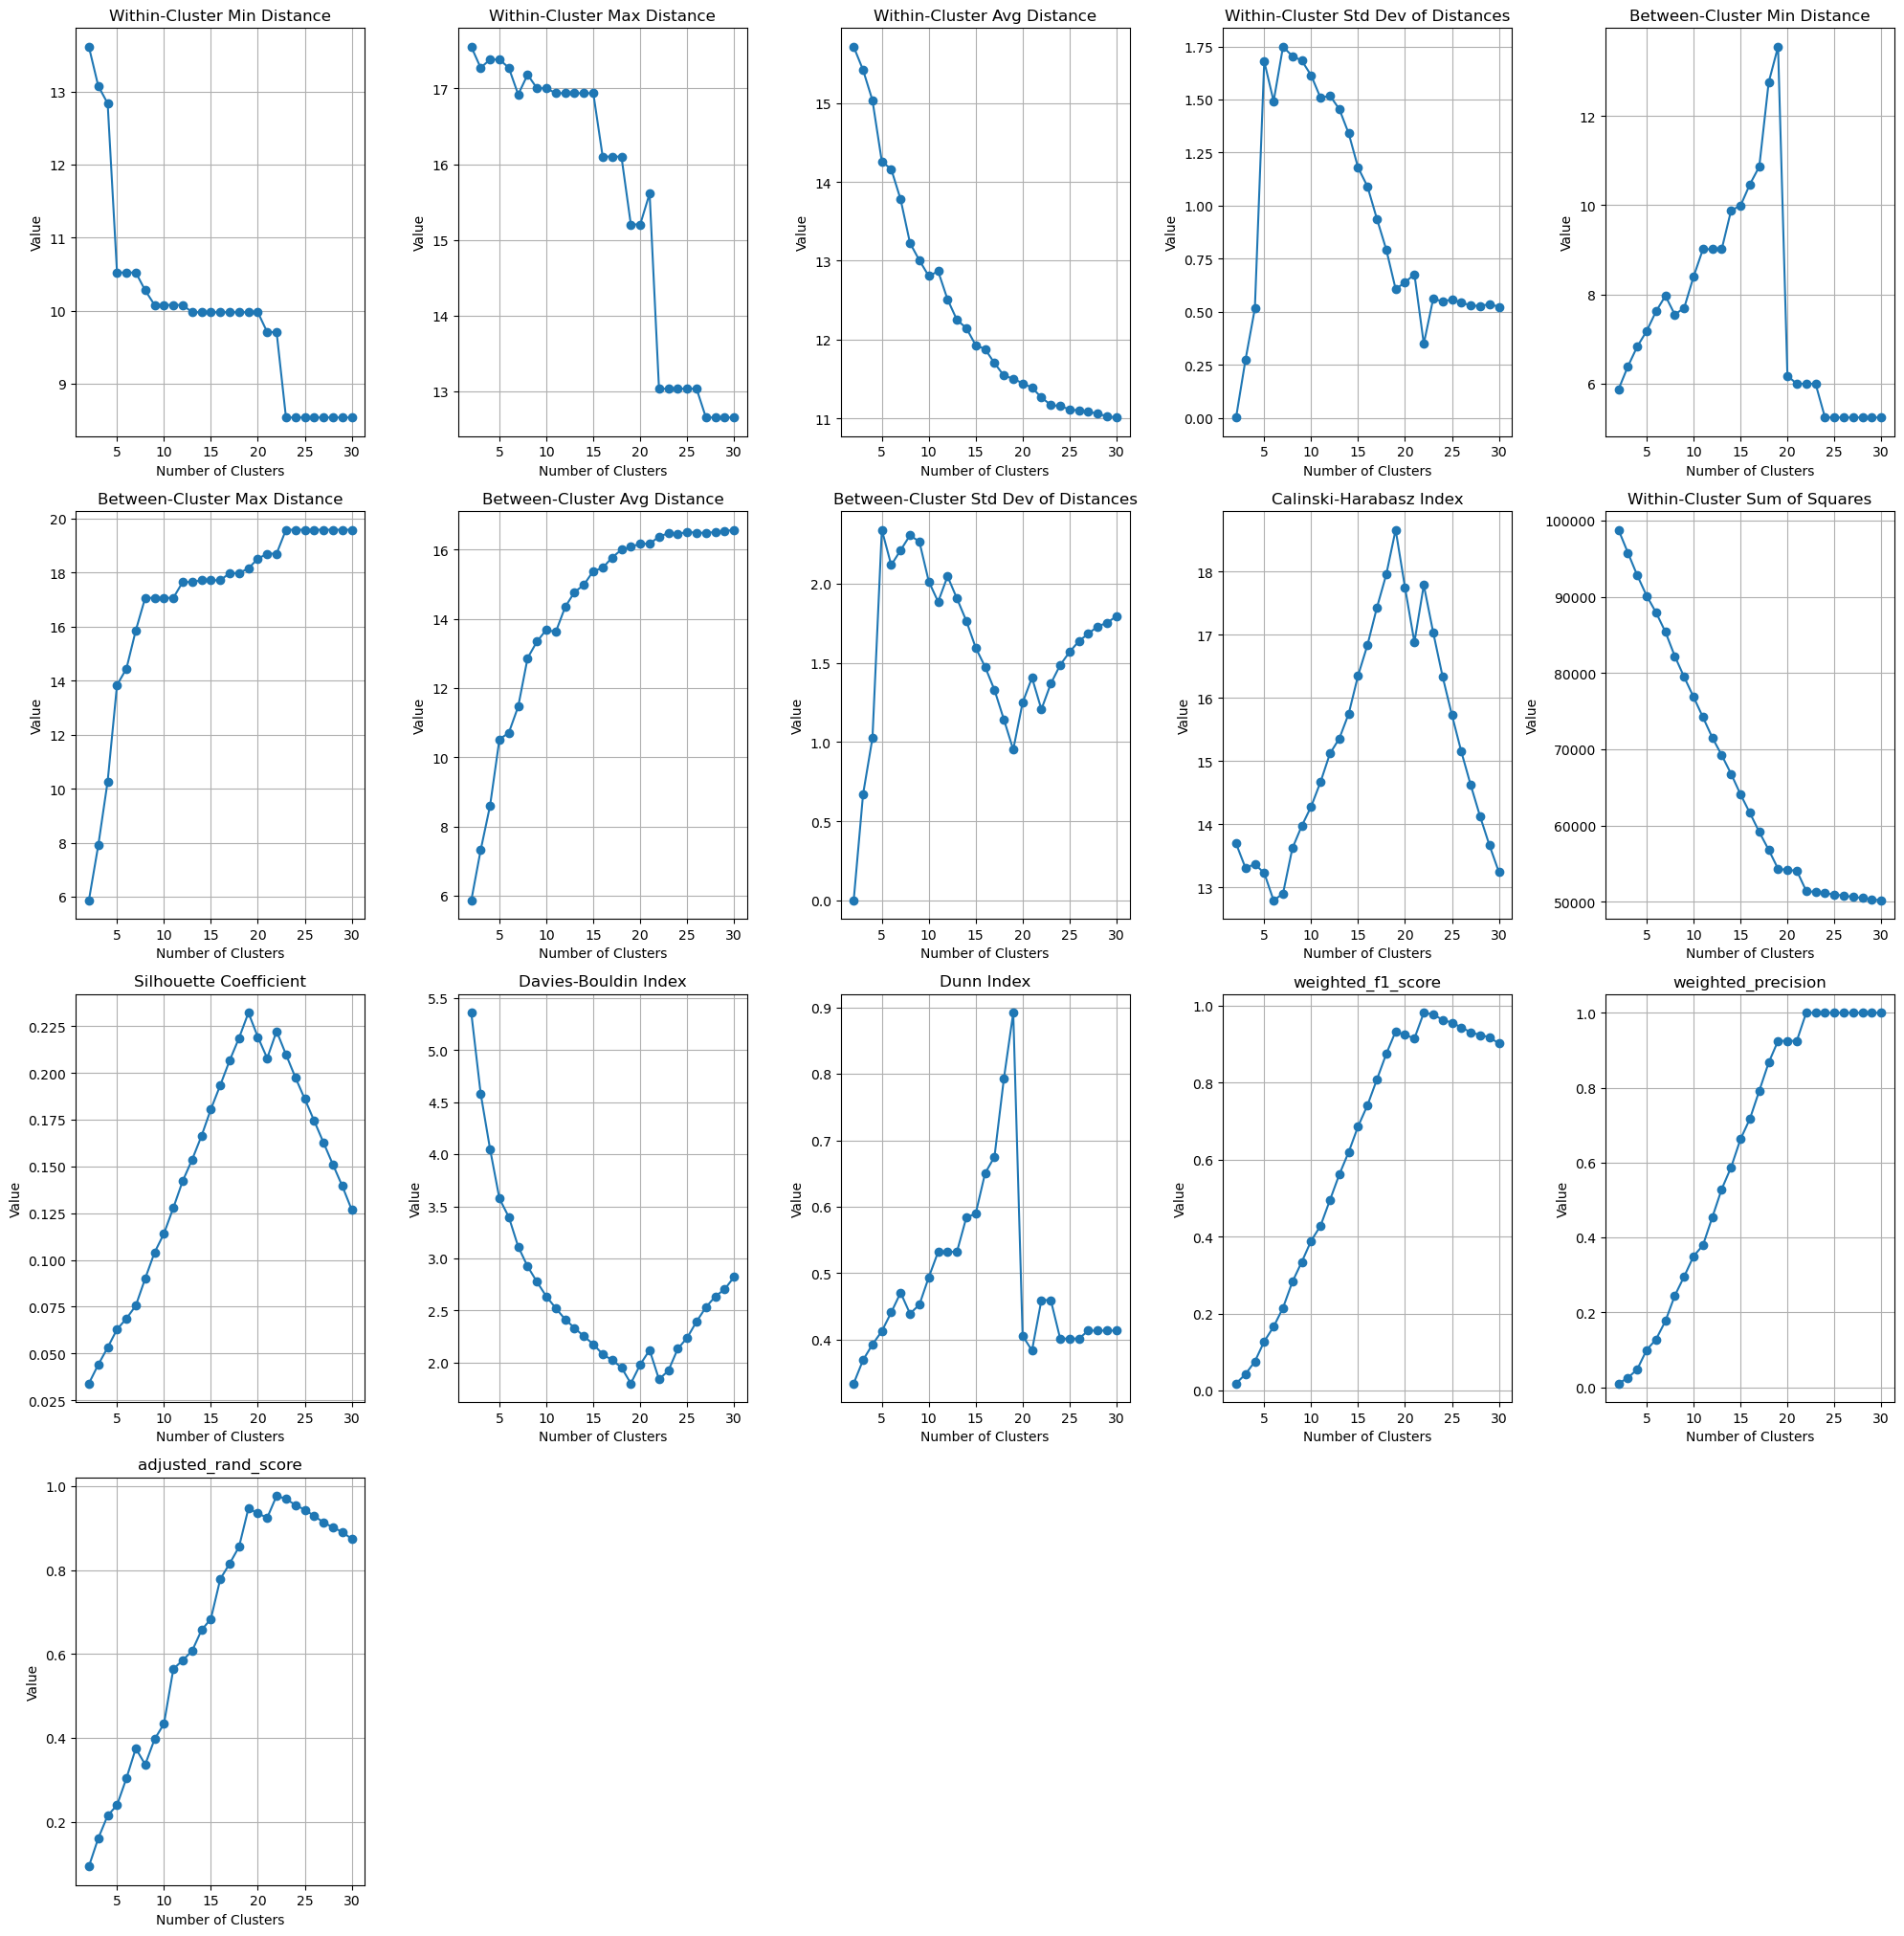

In [54]:
df = MERGED_DF
df = df[(df["model"] == "Synthetic") & (df["dataset"] == "Synthetic 20c 20n")]
df = df.reset_index(drop=True)

embeddings = np.stack(df["embedding"].to_numpy())
true_labels = df["label"].to_numpy()

print("Actual Number of Individuals", len(np.unique(true_labels)))
kmeans_metrics = find_optimal_kmeans(embeddings, true_labels, max_clusters=30, step=1)
visualize_alg_metrics(kmeans_metrics, formatted_names)

### Synthetic Test Large (200 clusters; 10 image per cluster)

We see very clearly that these metrics perform well at identifying clusters.

- min David Bouldin Index
- max siluette score
- != 0: 2nd derivative of wcss (inertia) [elbow method] perform


Actual Number of Individuals 200


Running K-means:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running K-means:   5%|▌         | 1/20 [00:02<00:49,  2.62s/it]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running K-means:  10%|█         | 2/20 [00:05<00:47,  2.64s/it]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set

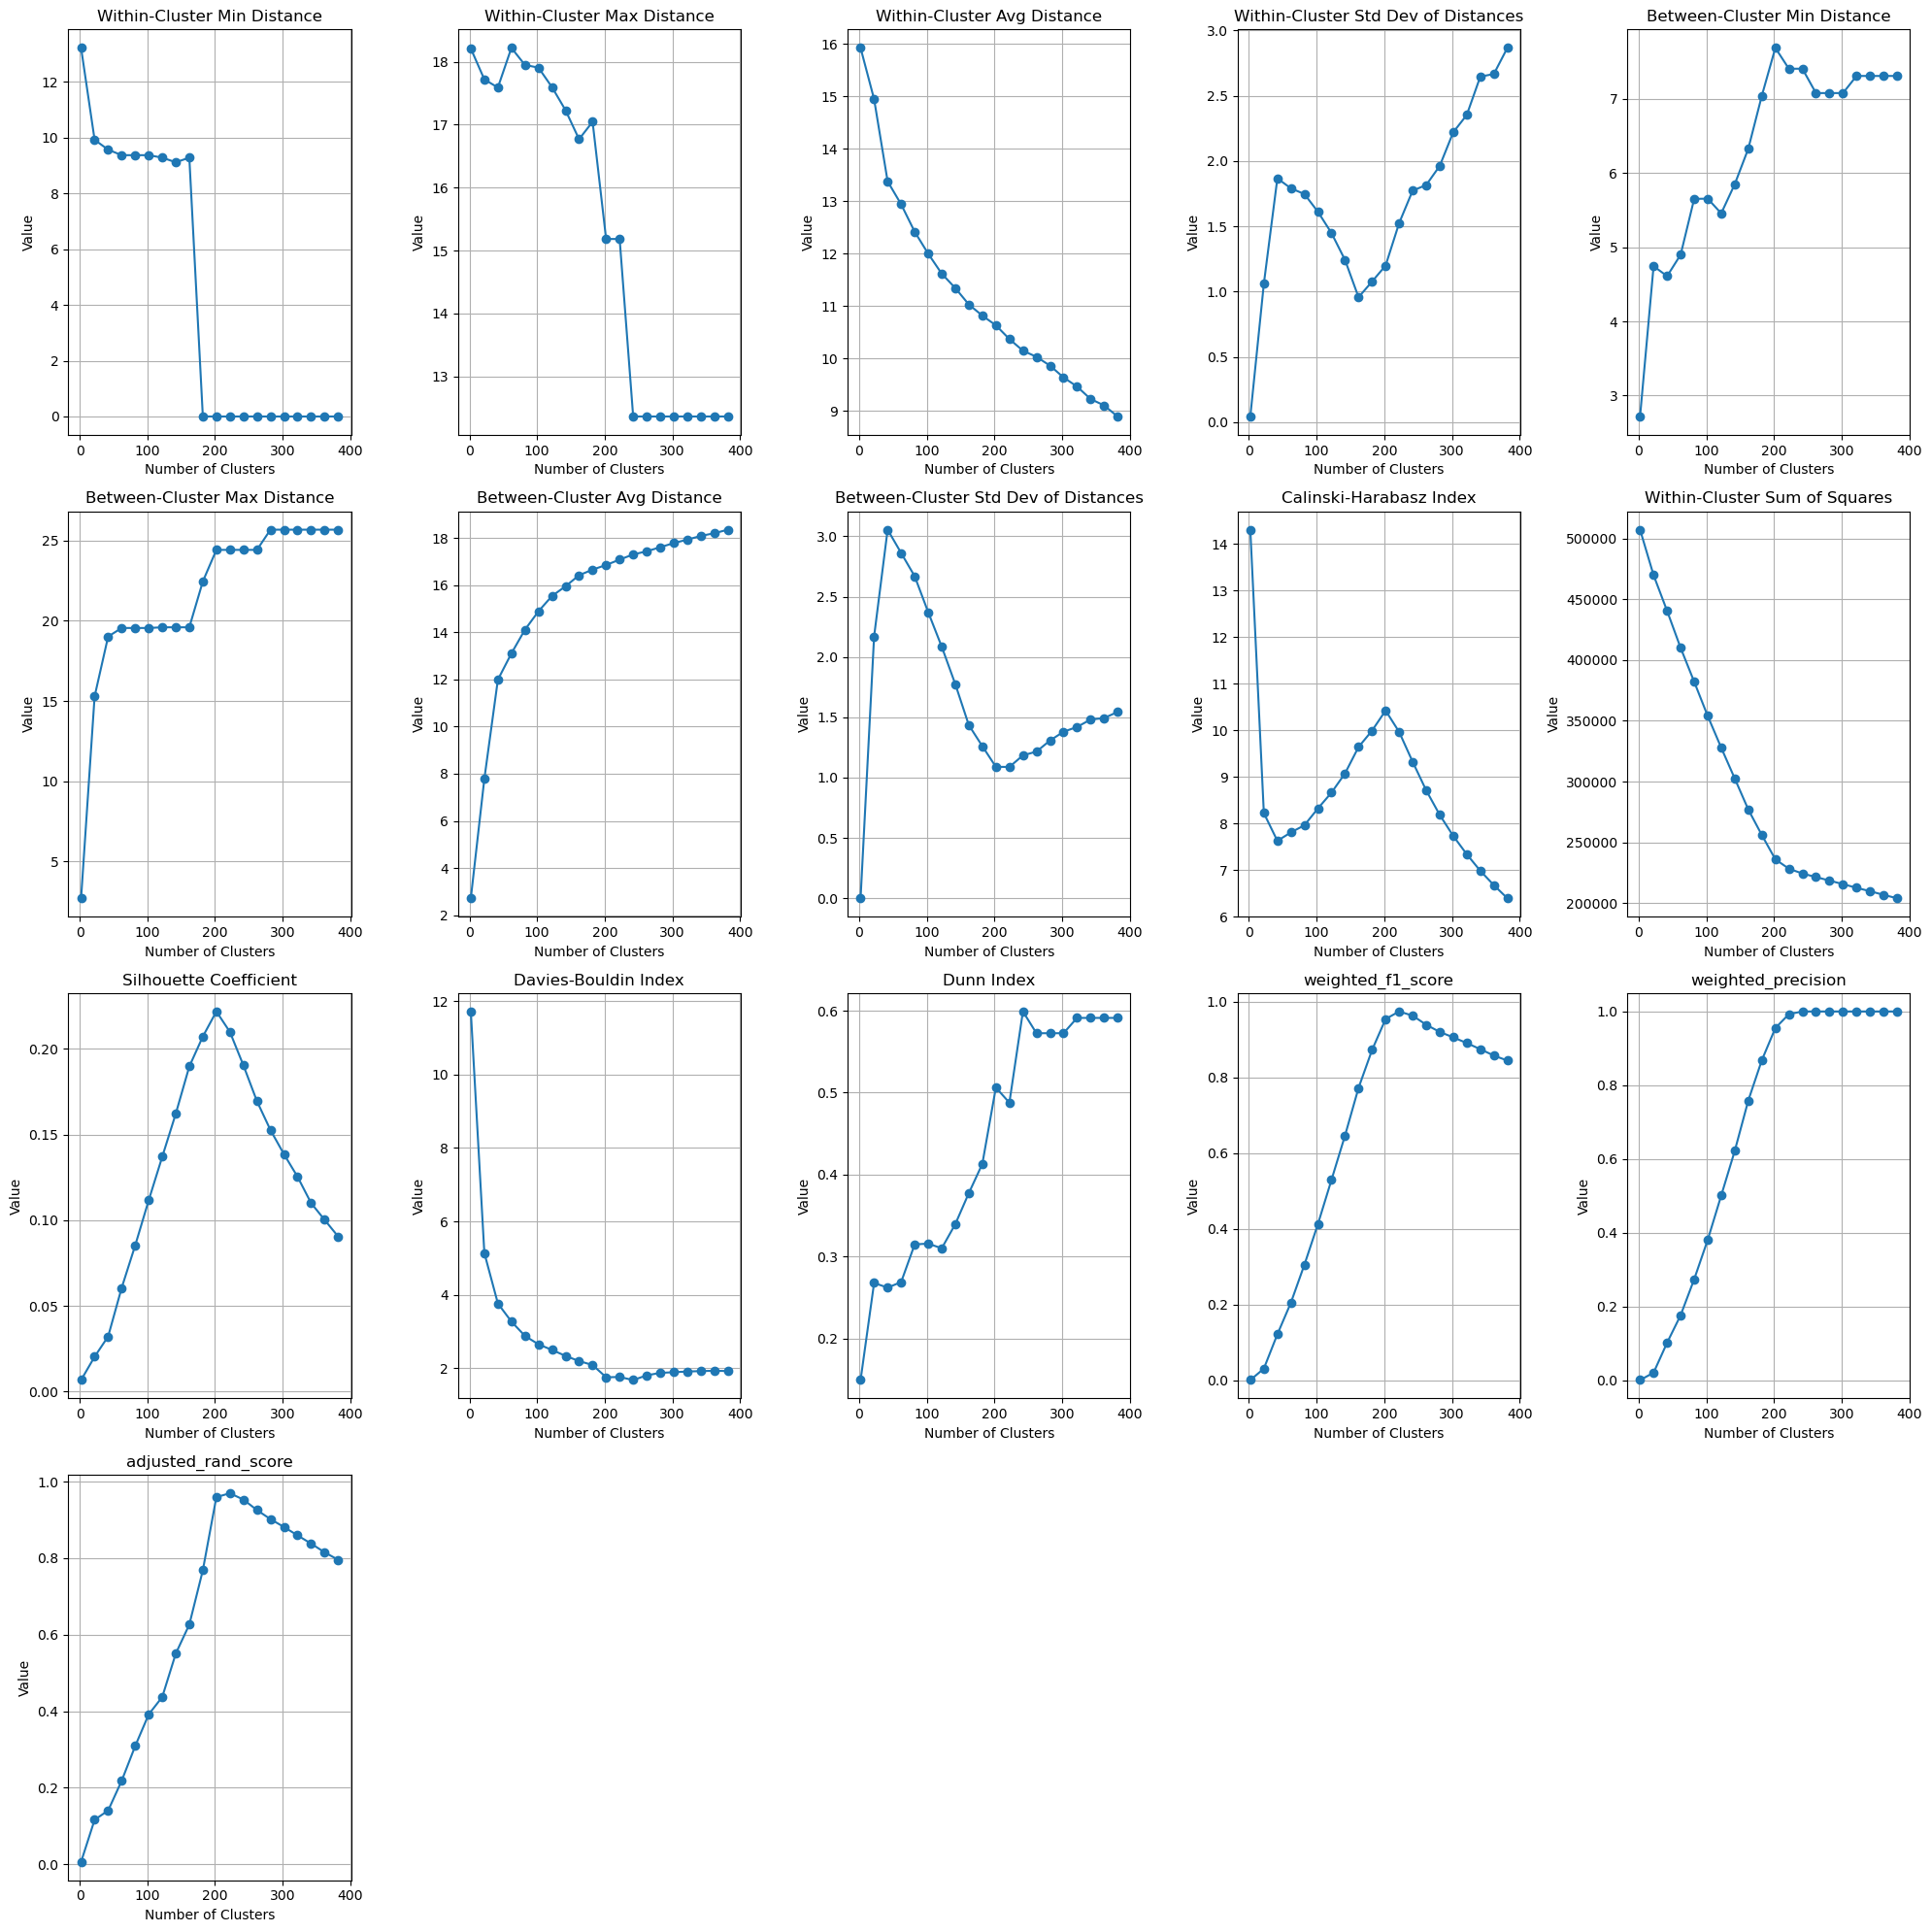

In [56]:
df = MERGED_DF
df = df[(df["model"] == "Synthetic") & (df["dataset"] == "Synthetic 200c 10n")]
df = df.reset_index(drop=True)

embeddings = np.stack(df["embedding"].to_numpy())
true_labels = df["label"].to_numpy()

print("Actual Number of Individuals", len(np.unique(true_labels)))
kmeans_metrics = find_optimal_kmeans(embeddings, true_labels, max_clusters=400, step=20)
visualize_alg_metrics(kmeans_metrics, formatted_names)

# Agglomorative Clustering

### Synthetic

In [73]:
df = MERGED_DF
df = df[(df["model"] == "Synthetic") & (df["dataset"] == "Synthetic 200c 10n")]
df = df.reset_index(drop=True)

embeddings = np.stack(df["embedding"].to_numpy())
true_labels = df["label"].to_numpy()

print("Actual Number of Individuals", len(np.unique(true_labels)))
agg_metrics = find_optimal_agglomerative(embeddings, true_labels, max_clusters=400, step=20)
visualize_alg_metrics(agg_metrics, formatted_names)

Actual Number of Individuals 200


Running Agglomerative:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running Agglomerative:   5%|▌         | 1/20 [00:01<00:37,  1.96s/it]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running Agglomerative:  10%|█         | 2/20 [00:03<00:35,  1.96s/it]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-def

Actual Number of Individuals 20


Running Agglomerative:   0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running Agglomerative:   5%|▌         | 1/20 [00:00<00:02,  7.19it/s]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running Agglomerative:  10%|█         | 2/20 [00:00<00:04,  3.91it/s]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-def

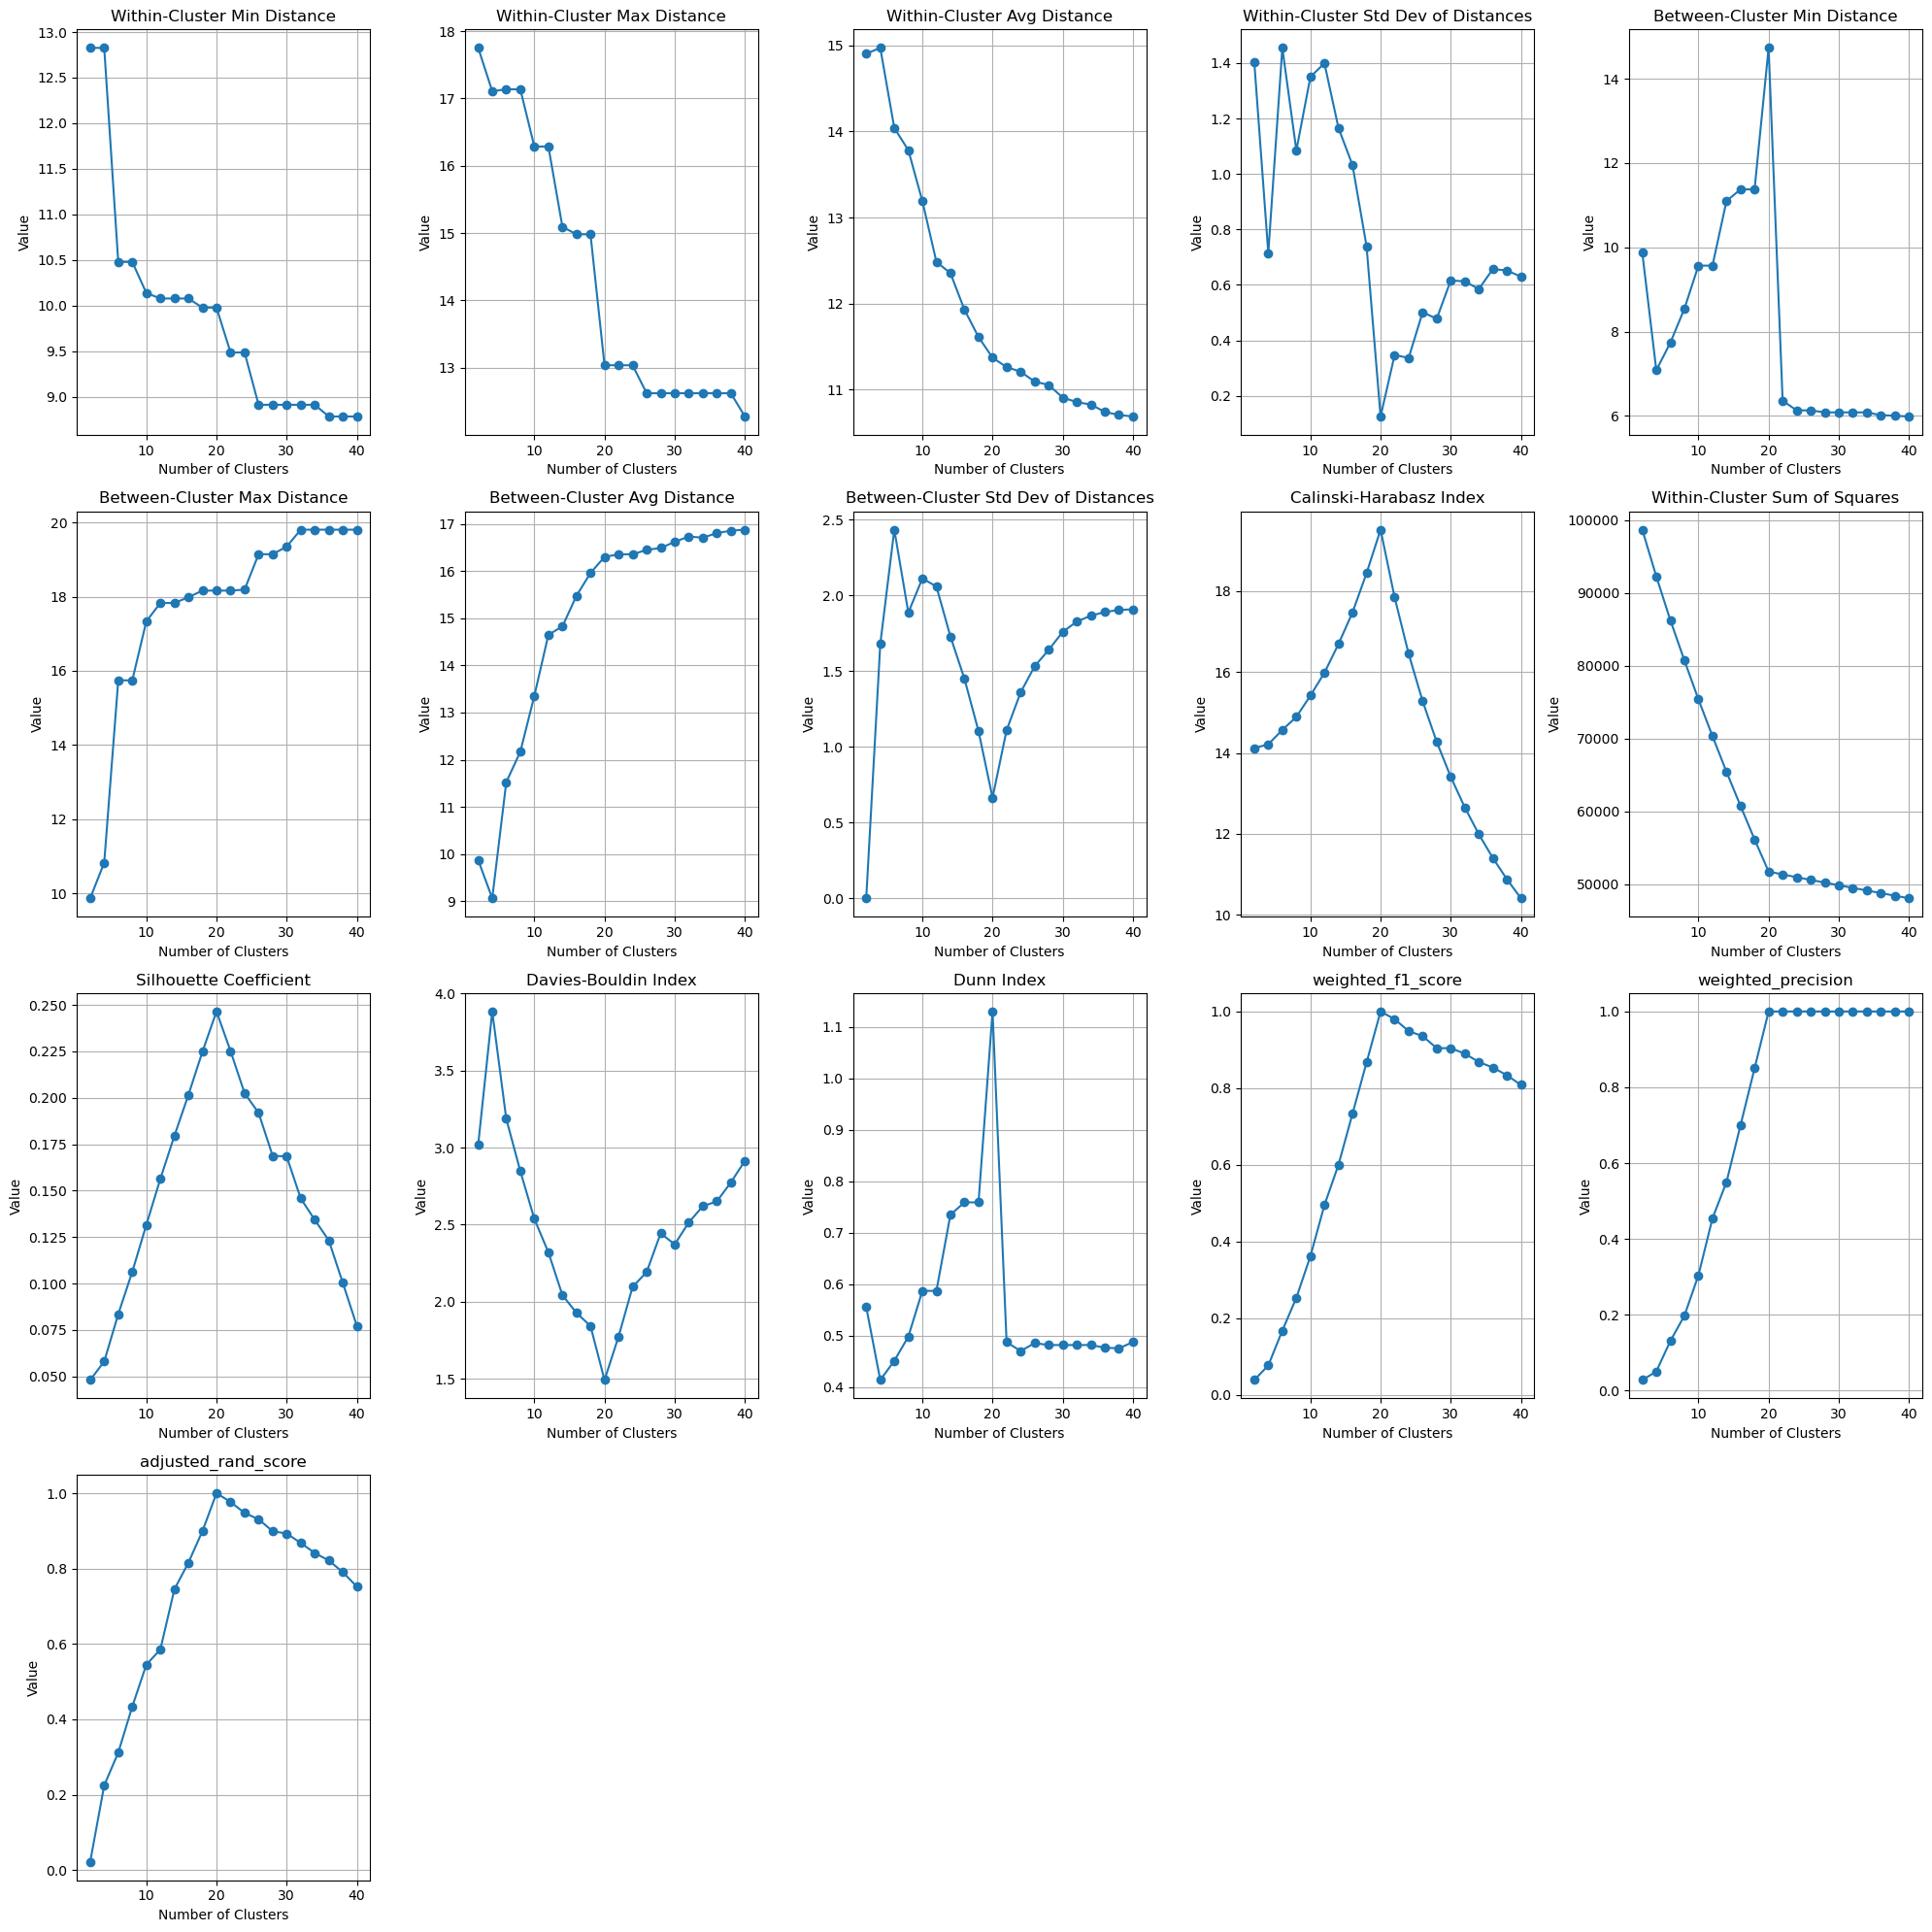

In [77]:
df = MERGED_DF
df = df[(df["model"] == "Synthetic") & (df["dataset"] == "Synthetic 20c 20n")]
df = df.reset_index(drop=True)

embeddings = np.stack(df["embedding"].to_numpy())
true_labels = df["label"].to_numpy()

print("Actual Number of Individuals", len(np.unique(true_labels)))
agg_metrics = find_optimal_agglomerative(embeddings, true_labels, max_clusters=40, step=2)
visualize_alg_metrics(agg_metrics, formatted_names)

### SPAC - ViT-Finetuned

In [78]:
df = MERGED_DF
df = df[(df["model"] == "ViT-Finetuned") & (df["dataset"] == "SPAC")]
df = df.reset_index(drop=True)

embeddings = np.stack(df["embedding"].to_numpy())
true_labels = df["label"].to_numpy()

print("Actual Number of Individuals", len(np.unique(true_labels)))
kmeans_metrics = find_optimal_agglomerative(embeddings, true_labels, max_clusters=180, step=5)
visualize_alg_metrics(kmeans_metrics, formatted_names)

Actual Number of Individuals 129


Running Agglomerative:   0%|          | 0/36 [00:00<?, ?it/s]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running Agglomerative:   3%|▎         | 1/36 [00:00<00:32,  1.07it/s]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running Agglomerative:   6%|▌         | 2/36 [00:01<00:33,  1.02it/s]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-def

Actual Number of Individuals 110


Running Agglomerative:   0%|          | 0/32 [00:00<?, ?it/s]

/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running Agglomerative:   3%|▎         | 1/32 [00:01<00:54,  1.76s/it]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running Agglomerative:   6%|▋         | 2/32 [00:03<01:00,  2.01s/it]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples

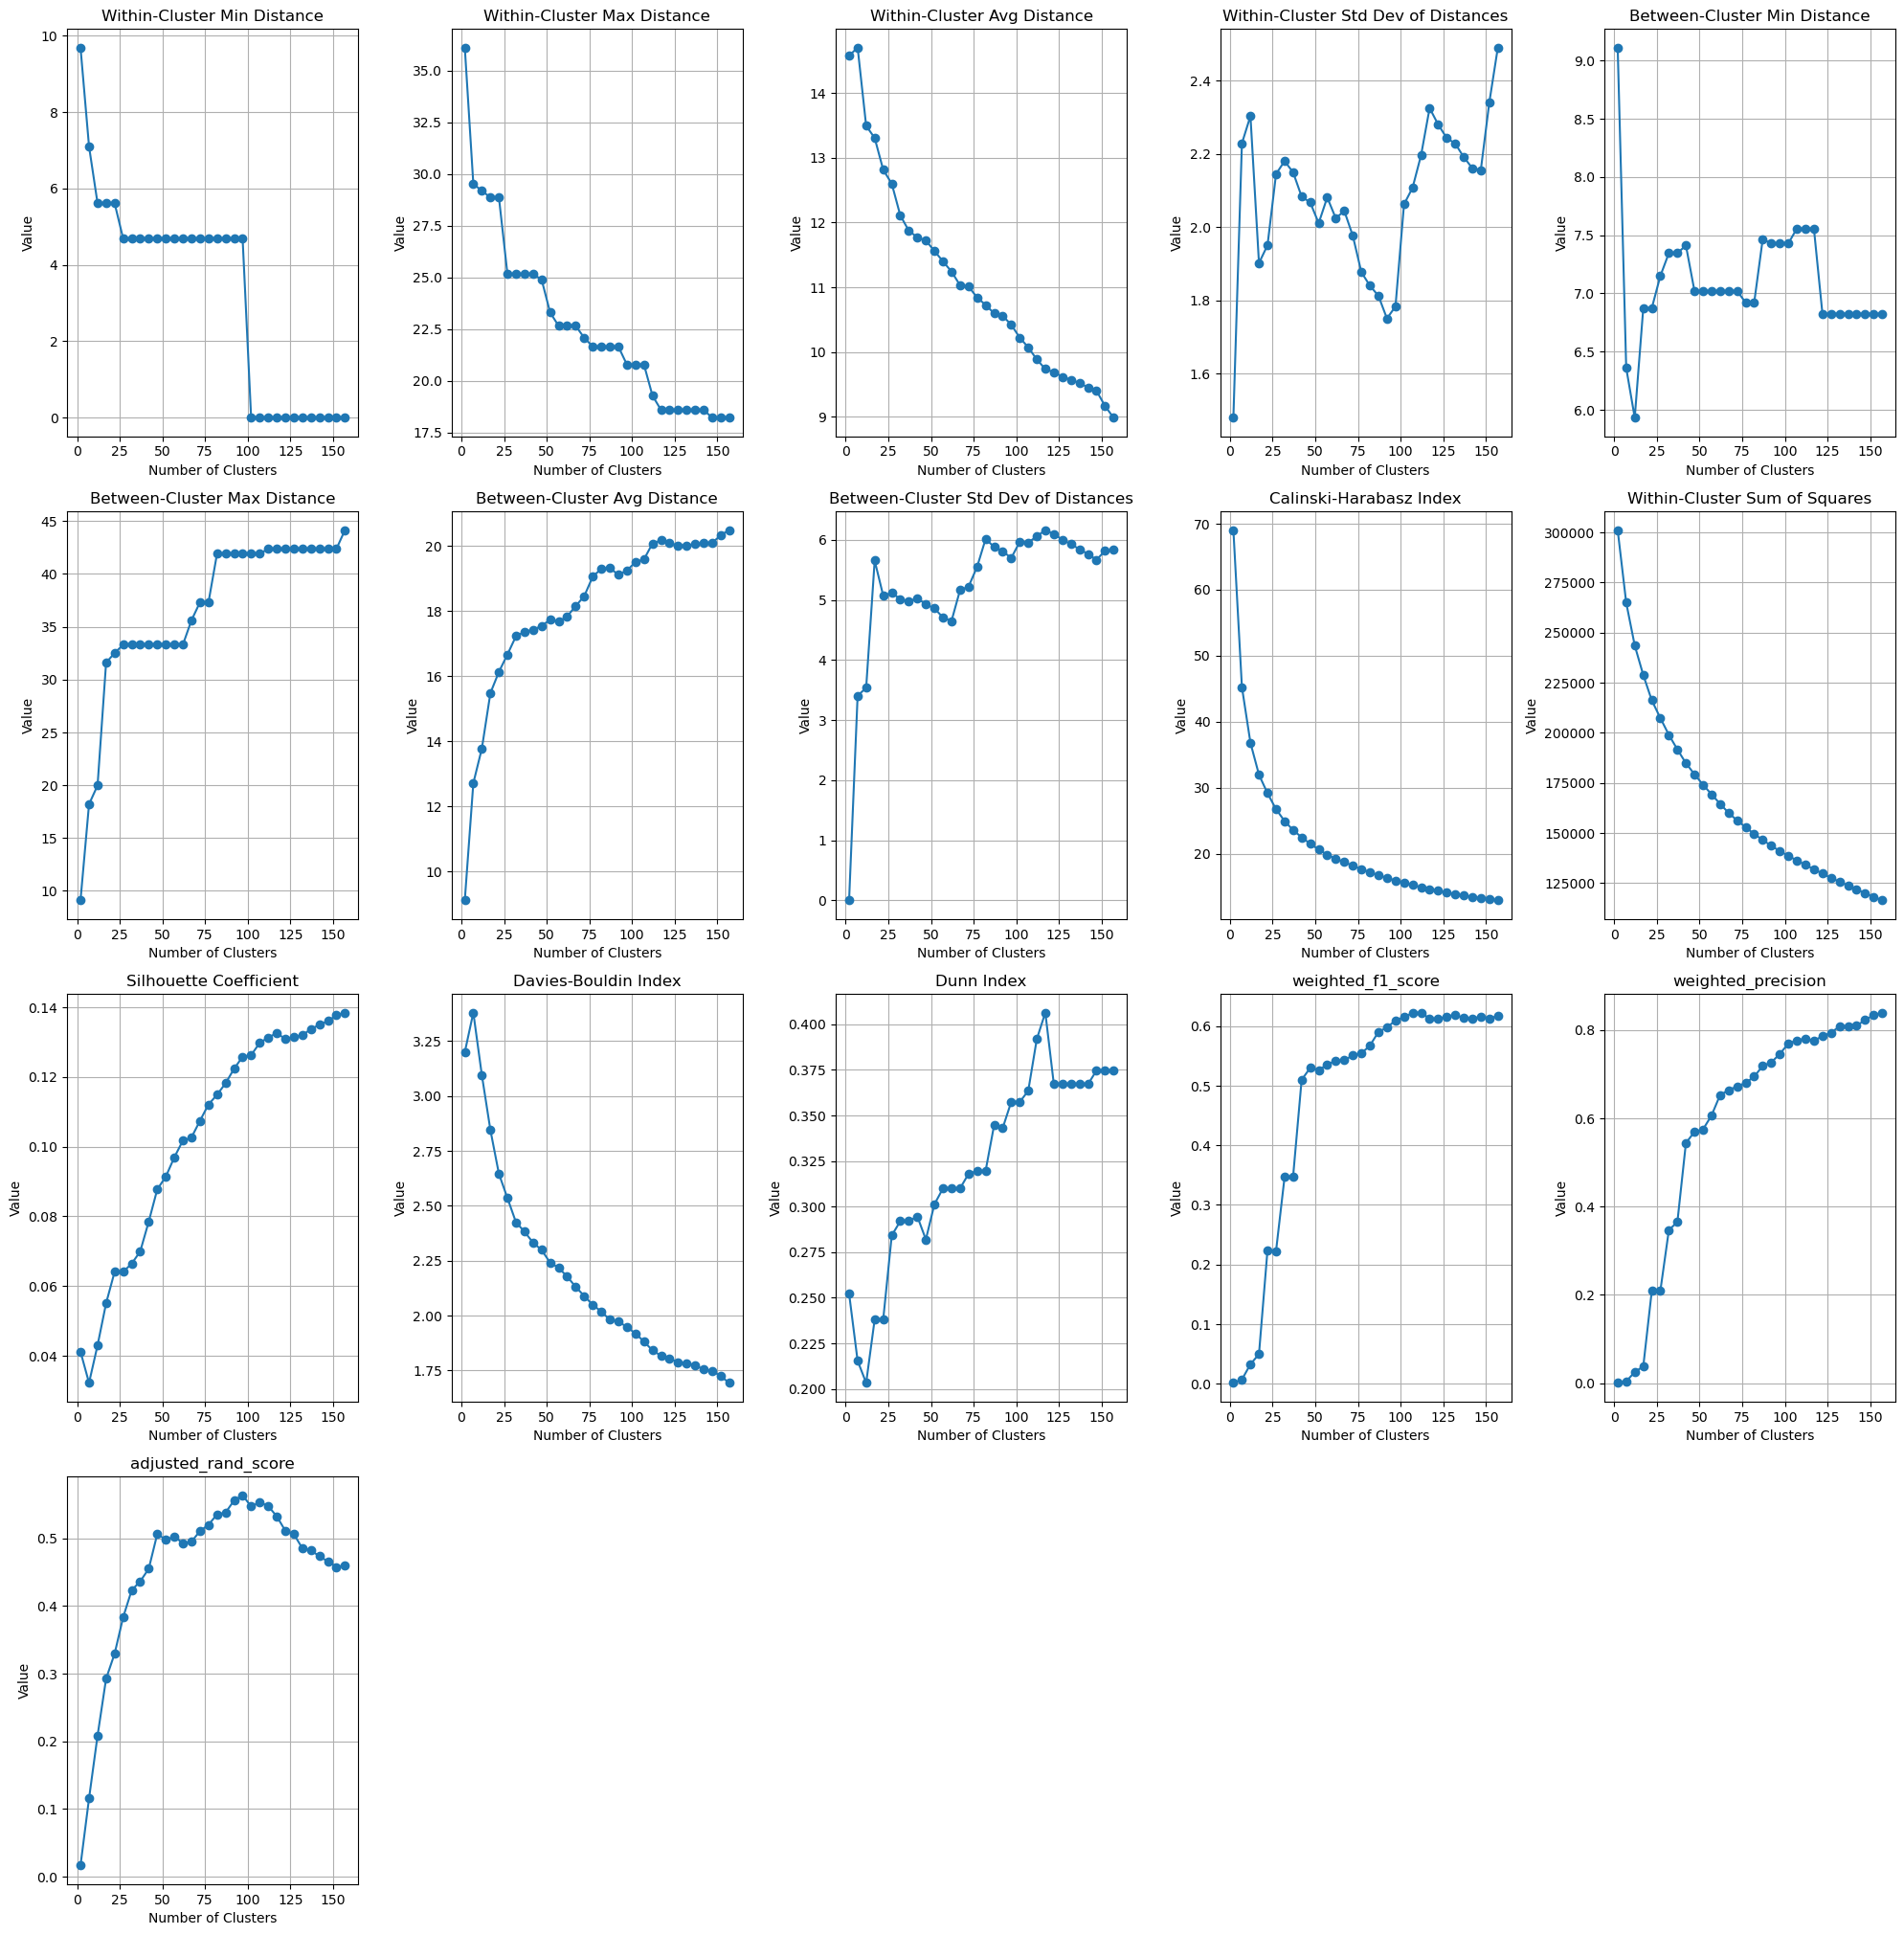

Actual Number of Individuals 110


Running Agglomerative:   0%|          | 0/32 [00:00<?, ?it/s]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running Agglomerative:   3%|▎         | 1/32 [00:00<00:13,  2.37it/s]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Running Agglomerative:   6%|▋         | 2/32 [00:00<00:13,  2.20it/s]/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-def

In [81]:
m3df = with_min_label_count(df, 3)
m3embeddings = np.stack(m3df["embedding"].to_numpy())
m3true_labels = m3df["label"].to_numpy()

print("Actual Number of Individuals", len(np.unique(m3true_labels)))
m3kmeans_metrics = find_optimal_agglomerative(m3embeddings, m3true_labels, max_clusters=160, step=5)
visualize_alg_metrics(m3kmeans_metrics, formatted_names)


m3ma10df = upto_max_label_count(m3df, 10)
m3ma10embeddings = np.stack(m3ma10df["embedding"].to_numpy())
m3ma10true_labels = m3ma10df["label"].to_numpy()

print("Actual Number of Individuals", len(np.unique(m3ma10true_labels)))
m3ma10kmeans_metrics = find_optimal_agglomerative(m3ma10embeddings, m3ma10true_labels, max_clusters=160, step=5)
visualize_alg_metrics(m3ma10kmeans_metrics, formatted_names)

# HDBSCAN

In [87]:
df = MERGED_DF
df = df[(df["model"] == "Synthetic") & (df["dataset"] == "Synthetic 200c 10n")]
df = df.reset_index(drop=True)

embeddings = np.stack(df["embedding"].to_numpy())
true_labels = df["label"].to_numpy()

print("Actual Number of Individuals", len(np.unique(true_labels)))
agg_metrics = find_optimal_hdbscan(embeddings, true_labels, min_cluster_size_range=list(range(2, 40)))
visualize_alg_metrics(agg_metrics, formatted_names)

Actual Number of Individuals 200


Running HDBSCAN:   0%|          | 0/38 [00:00<?, ?it/s]

Running HDBSCAN:  24%|██▎       | 9/38 [00:51<02:47,  5.77s/it]


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

# Sweep

In [1]:
from gorillatracker.classification.clustering import sweep_clustering_algorithms, configs, speed_level, visualize_alg_metrics, calculate_metrics, batch_visualize_alg_metrics, EXT_MERGED_DF, MERGED_DF, param_grid
from gorillatracker.classification.metrics import formatted_names
import pandas as pd

metrics_df = pd.read_pickle("results.pkl")
# visualize_alg_metrics(metrics_df, "SPAC", "ViT-Finetuned", "KMeans", formatted_names)
batch_visualize_alg_metrics(metrics_df, "Bristol", ["ViT-Pretrained", "ViT-Finetuned", "EfN-Pretrained"], ["KMeans", "AgglomerativeClustering"], formatted_names)

In [20]:
issue = ("Synthetic 200c 10n", "Synthetic", "AgglomerativeClustering", param_grid({"n_clusters": range(1, 410, 10)}))
# issue = ("SPAC", "ViT-Finetuned", "AgglomerativeClustering", param_grid({"n_clusters": range(1, 1000, 20)}))
ac = sweep_clustering_algorithms(EXT_MERGED_DF, [issue])

Processing configurations:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 1}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 11}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 21}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 31}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 41}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 51}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 61}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 71}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 81}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 91}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 101}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 111}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 121}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 131}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 141}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 151}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 161}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 171}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 181}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 191}


/opt/conda/envs/research/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 201}
Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 211}
Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 221}
Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 231}
Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 241}
Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 251}
Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 261}
Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 271}
Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 281}
Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 291}
Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters': 301}
Processing Synthetic 200c 10n Synthetic AgglomerativeClustering {'n_clusters

Processing configurations: 100%|██████████| 1/1 [01:42<00:00, 102.41s/it]
